# SI 618 WN Project Part I

## Project Title:
> Provide a descriptive working title for your project.

**Game Sales, Popularity, and Achievements: A Comparative Analysis Across Platforms**

## Team Members
> List each team member and include their uniqname

* Yufeng Song (yfsong)
* Ziqi Wang (Venchy)
* Muyu Lin (linmuyu)

## Overview
> Give a high level description of your project

Our project explores key trends in the gaming industry by analyzing data on game sales, player achievements, and platform preferences. We aim to understand how the same game performs across different platforms, how purchasing preferences vary across countries, and how game popularity evolves over time. Additionally, we will investigate the relationship between supported languages and sales, as well as the impact of pricing on game popularity across multiple platforms. By analyzing these factors, we hope to uncover insights into player behavior, market trends, and factors influencing game success.

## Motivation
> Explain why you chose this particular topic for your project.	Include the three "real-world" questions that you generated about the data, and be sure to explain what you hope to learn by answering them.

We chose this topic because gaming is a massive industry with a highly diverse audience, and understanding player preferences and market trends can provide valuable insights for developers, publishers, and gaming communities. Our project aims to answer the following real-world questions:

1. **How do game genres, game pricing, and in-game achievements differ across platforms for the same game?**

  - By analyzing achievement data, we aim to understand whether players engage with a game differently depending on the platform they use. This could reveal differences in play styles, game difficulty adjustments, or platform-specific engagement trends.

2. **How do game purchase preferences vary by country?**

  - We seek to determine whether purchasing behaviors differ based on regional preferences. Understanding this can help developers tailor their marketing strategies and optimize game pricing for different audiences.

3. **How has the popularity of different game types changed over time (`release_date`)?**

  - By tracking shifts in game genre popularity over time, we hope to uncover trends that indicate the rise and fall of specific genres. This insight could be useful for predicting future market demands and guiding game development strategies.


By answering these questions, we hope to gain a deeper understanding of the gaming landscape, helping stakeholders make data-driven decisions about game development, pricing, and distribution strategies.

## Data Sources
> List the two (or more) sources of data that you'll be using.  Provide URLs where appropriate.	**Explain how the two (or more) datasets complement each other.**

1. https://www.kaggle.com/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox

2. https://github.com/Smipe-a/gamestatshub

- This Gaming Profiles Data from Kaggle include **game** and **player** data from three different **platforms**, PlayStation, Steam, and Xbox.
- For each platform, the **player** and **game** data is complemented by **achievement** data. The relationships between players, games, and achievements are one-to-many: each player can play multiple games, and each game can have multiple achievements.
- Data from the three platforms can be combined based on **game titles** to analyze shared games across platforms.

## Data Description
> List the variables of interest, the size of the data sets, missing values, etc.

### Common Datasets Across 3 Platforms & Variables of Interest:

#### Player Metadata
- **players.csv**: platform-specific `playerid` and `country` (Xbox data lacks country column)
- **purchased_games.csv** lists players' purchased games, with:
    - `playerid`
    - `libarary`: a list of games the player bought.
- **history.csv**: when the player unlocked the achievement.
    - `playerid`
    - `achievementid`
    - `date_acquired`

#### Game Metadata
- **games.csv**: game details such as `genres`, `developers`, `publishers`, `supported_language`, and `release_date`.
- **achievements.csv** maps achievements to their respective game, with:
    - `achievementid` combines the uniqe game id on the platform and the achievement id within the game
    - `gameid`
    - `title`
    - `description`
- **prices.csv**: games' price in various currencies, with `date_acquired` indicating the date when the price was recorded.

## Data Manipulation
> Mostly code in this section.  This is where you merge your data sets, as well as create new columns (if appropriate)

#### Merged Datasets Explained - Flattened Table For Raw Analysis
- Platform-Specific Datasets:
    - Player-Info Dataset: merged on `playerid`
    - Game-Info Dataset: merged on `gameid`
- Cross-Platform Game Dataset: merged on game `title` to combine shared game data from all three platforms.

**Notes**: 
- In all the merged datasets, there are duplicated gameid/playerid after merge due to the one-to-many relationship between players, games, and achievements. 
- In the corss-platform game table, there are duplicated game titles across platforms.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## PS

In [4]:
import os

PS_DATA_FOLDER = "data/ps"

dfs = {}

for root, dirs, files in os.walk(PS_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')  # Clean name
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")

ps_purchased_games - shape: (46582, 2)
ps_history - shape: (19510083, 3)
ps_prices - shape: (62816, 7)
ps_players - shape: (356600, 3)
ps_games - shape: (23151, 8)
ps_achievements - shape: (846563, 5)


In [5]:
ps_achievements = dfs['ps_achievements']
ps_games = dfs['ps_games']
ps_history = dfs['ps_history']
ps_players = dfs['ps_players']
ps_prices = dfs['ps_prices']
ps_purchased_games = dfs['ps_purchased_games']

# check duplicates
print(ps_games.duplicated(subset=["gameid"]).sum())
print(ps_prices.duplicated(subset=["gameid"]).sum())
print(ps_achievements.duplicated(subset=["achievementid"]).sum())
print(ps_players.duplicated(subset=["playerid"]).sum())
print(ps_purchased_games.duplicated(subset=["playerid"]).sum())

0
32095
0
0
0


In [6]:
ps_prices['gameid'].value_counts()

gameid
726666    3
723091    3
727730    3
727729    3
728792    3
         ..
421567    2
421164    2
421153    2
421368    2
423969    2
Name: count, Length: 30721, dtype: int64

In [7]:
ps_prices[ps_prices['gameid'] == 726666]

,gameid,usd,eur,gbp,jpy,rub,date_acquired
20167,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-22
50835,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-25
52307,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-24


In [8]:
# for each gameid, keep only the most recent price entry
ps_prices = ps_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(ps_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [9]:
ps_player_info = ps_players.merge(ps_history, on="playerid", how="left")

In [10]:
ps_player_info = ps_player_info.merge(ps_achievements, on="achievementid", how="left")

In [11]:
ps_player_info = ps_player_info.merge(ps_purchased_games, on="playerid", how="left")

In [12]:
ps_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19861683 entries, 0 to 19861682
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   country        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   rarity         object 
 9   library        object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.5+ GB


In [13]:
ps_player_info.sample(5)

,playerid,nickname,country,achievementid,date_acquired,gameid,title,description,rarity,library
7171797,370618,jy1252w,Hong Kong,8219_100582,2016-01-13 10:08:05,8219.0,望む世界,鉤翅のエンディングを見た,Silver,"[615078, 8600, 440433, 699413, 559475, 427963,..."
17534392,4732297,Bozmir,Poland,10406_120192,2016-11-14 03:29:10,10406.0,20 Headshots,Kill 20 Enemies with Headshots,Bronze,"[648531, 438873, 438874, 549575, 137936, 51401..."
11379381,292336,Bamsibams,Sweden,660940_5384898,2024-08-31 20:37:49,660940.0,Fallen from Heaven,Defeated Cherubim.,Bronze,"[702259, 569095, 588790, 618930, 702260, 69082..."
13680320,62005,BjornTheHearthen,Denmark,139673_2502109,2018-07-09 12:08:00,139673.0,A super-predator,Release a Spinosaurus,Bronze,"[433849, 697062, 696640, 593579, 628676, 45409..."
14710151,85684,Bruiserk,Canada,2_717,2010-03-19 00:51:11,2.0,Three Wise Men,Solve the Three Judges,Bronze,"[399413, 10406, 8600, 137118, 163258, 175313, ..."


### Game focus
date_acquired column is dropped as it indicates the timestamp when the price info was extracted from multiple databases and do not add helpful insights to our analysis.

In [14]:
ps_game_info = ps_games.merge(ps_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [15]:
ps_game_info = ps_game_info.merge(ps_prices, on="gameid", how="left")

In [16]:
ps_game_info = ps_game_info.drop(columns=['date_acquired'])

In [17]:
ps_game_info.rename(columns={'platform': 'PS_platform'}, inplace=True)

In [18]:
ps_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [19]:
ps_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626958 entries, 0 to 626957
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   626958 non-null  int64  
 1   title                    626958 non-null  object 
 2   PS_platform              626958 non-null  object 
 3   developers               626416 non-null  object 
 4   publishers               626624 non-null  object 
 5   genres                   623044 non-null  object 
 6   supported_languages      319860 non-null  object 
 7   release_date             626958 non-null  object 
 8   achievementid            626958 non-null  object 
 9   achievement_title        626954 non-null  object 
 10  achievement_description  626942 non-null  object 
 11  rarity                   626958 non-null  object 
 12  usd                      535794 non-null  float64
 13  eur                      508924 non-null  float64
 14  gbp 

PS-only cols: rarity, PS_platform

In [20]:
ps_game_info.sample(5)

,gameid,title,PS_platform,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,rarity,usd,eur,gbp,jpy,rub
32442,682519,Alone in the Dark: The New Nightmare (2001),PS5,['Darkworks'],['THQ Nordic'],['Survival Horror'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-04-16,682519_5516592,Dark-Winged Menace,Defeat the Procuraptor in the Manor Library.,Silver,9.99,9.99,7.99,1320.0,NaN
228648,183409,Submersed,PS4,['Main Loop'],['Factoria Cultural Gestio'],['Adventure'],"['French', 'Spanish', 'German', 'Italian', 'Po...",2019-03-27,183409_3031485,Searching for answers,Finish the Chapter 05,Bronze,1.94,1.94,1.68,NaN,NaN
422839,640352,Draco D,PS4,['Smobile'],['Smobile'],"[""Shoot 'em up""]",NaN,2023-12-20,640352_5253923,Kill an enemy dragon,Kill an enemy dragon while flying.,Gold,6.99,6.99,5.79,880.0,NaN
179525,421234,Puyo Puyo Tetris 2,PS5,['SEGA'],['SEGA'],['Puzzle'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2020-12-08,421234_3819707,Devotee,Achieved 70% completion in\nAdventure mode,Silver,39.99,39.99,34.99,NaN,NaN
457188,593040,Gruta,PS5,['Capi Capi'],['Ratalaika Games'],['Platformer'],NaN,2023-05-05,593040_4907732,Bat Hunter,Kill 100+ enemies,Gold,NaN,NaN,NaN,NaN,NaN


In [21]:
ps_game_info['achievementid'].value_counts()

achievementid
749375_6098396    1
650405_5312282    1
650406_5312373    1
650406_5312374    1
650406_5312375    1
                 ..
336965_3248824    1
336965_3248825    1
336965_3248826    1
336965_3248827    1
7593_93460        1
Name: count, Length: 626958, dtype: int64

## Steam

In [22]:
import os
import pandas as pd

STEAM_DATA_FOLDER = "data/steam"

dfs = {}

for root, dirs, files in os.walk(STEAM_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')  # Clean name
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")


steam_purchased_games - shape: (102548, 2)
steam_reviews - shape: (1204534, 8)
steam_history - shape: (10693879, 3)
steam_friends - shape: (424683, 2)
steam_prices - shape: (4414273, 7)
steam_players - shape: (424683, 3)
steam_games - shape: (98248, 7)
steam_private_steamids - shape: (227963, 1)
steam_achievements - shape: (1939027, 4)


In [23]:
steam_achievements = dfs['steam_achievements']
steam_games = dfs['steam_games']
steam_history = dfs['steam_history']
steam_players = dfs['steam_players']
steam_prices = dfs['steam_prices']
steam_purchased_games = dfs['steam_purchased_games']

# check duplicates
print(steam_games.duplicated(subset=["gameid"]).sum())
print(steam_prices.duplicated(subset=["gameid"]).sum())
print(steam_achievements.duplicated(subset=["achievementid"]).sum())
print(steam_players.duplicated(subset=["playerid"]).sum())
print(steam_purchased_games.duplicated(subset=["playerid"]).sum())

0
4315808
0
0
0


In [24]:
# for each gameid, keep only the most recent price entry
steam_prices = steam_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(steam_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [25]:
st_player_info = steam_players.merge(steam_history, on="playerid", how="left")

In [26]:
st_player_info = st_player_info.merge(steam_achievements, on="achievementid", how="left")

In [27]:
st_player_info = st_player_info.merge(steam_purchased_games, on="playerid", how="left")

# # Save player-focused data
# steam_player_info.to_csv('data/steam_players.csv', index=False)

In [28]:
st_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113724 entries, 0 to 11113723
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   country        object 
 2   created        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   library        object 
dtypes: float64(1), int64(1), object(7)
memory usage: 763.1+ MB


In [29]:
st_player_info.shape

(11113724, 9)

In [30]:
st_player_info.head(5)

,playerid,country,created,achievementid,date_acquired,gameid,title,description,library
0,76561198287452552,Brazil,2016-03-02 06:14:20,NaN,NaN,NaN,NaN,NaN,"[10, 80, 100, 240, 2990, 6880, 6910, 6920, 698..."
1,76561198040436563,Israel,2011-04-10 17:10:06,NaN,NaN,NaN,NaN,NaN,"[10, 80, 100, 300, 20, 30, 40, 50, 60, 70, 130..."
2,76561198049686270,NaN,2011-09-28 21:43:59,NaN,NaN,NaN,NaN,NaN,NaN
3,76561198155814250,Kazakhstan,2014-09-24 19:52:47,NaN,NaN,NaN,NaN,NaN,NaN
4,76561198119605821,NaN,2013-12-26 00:25:50,NaN,NaN,NaN,NaN,NaN,"[47870, 108600, 550, 271590, 331470, 381210, 2..."


### Game focus

In [31]:
st_game_info = steam_games.merge(steam_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [32]:
st_game_info = st_game_info.merge(steam_prices, on="gameid", how="left")

In [33]:
st_game_info = st_game_info.drop(columns=['date_acquired'])

In [34]:
st_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [35]:
st_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983659 entries, 0 to 1983658
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  usd                      float64
 11  eur                      float64
 12  gbp                      float64
 13  jpy                      float64
 14  rub                      float64
dtypes: float64(5), int64(1), object(9)
memory usage: 227.0+ MB


In [36]:
st_game_info.shape

(1983659, 15)

In [37]:
st_game_info['achievementid'].value_counts()

achievementid
3266470_ACHIEVEMENT_5_MINUTES    1
2578790_Liquidator               1
2578790_Space_Rebel              1
2578790_Slugger                  1
2578790_Sergeant                 1
                                ..
1098080_ACHIEVEMENT_9            1
1098080_ACHIEVEMENT_8            1
1098080_ACHIEVEMENT_7            1
1098080_ACHIEVEMENT_6            1
1499240_ROMANROCKS               1
Name: count, Length: 1935882, dtype: int64

## XBOX

In [38]:
import os
import pandas as pd

XBOX_DATA_FOLDER = "data/xbox"

dfs = {}

for root, dirs, files in os.walk(XBOX_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")


xbox_purchased_games - shape: (46466, 2)
xbox_history - shape: (15275900, 3)
xbox_prices - shape: (22638, 7)
xbox_players - shape: (274450, 2)
xbox_games - shape: (10489, 7)
xbox_achievements - shape: (351111, 5)


In [39]:
xbox_achievements = dfs['xbox_achievements']
xbox_games = dfs['xbox_games']
xbox_history = dfs['xbox_history']
xbox_players = dfs['xbox_players']
xbox_prices = dfs['xbox_prices']
xbox_purchased_games = dfs['xbox_purchased_games']

# check duplicates
print(xbox_games.duplicated(subset=["gameid"]).sum())
print(xbox_prices.duplicated(subset=["gameid"]).sum())
print(xbox_achievements.duplicated(subset=["achievementid"]).sum())
print(xbox_players.duplicated(subset=["playerid"]).sum())
print(xbox_purchased_games.duplicated(subset=["playerid"]).sum())

0
11319
0
0
0


In [40]:
# for each gameid, keep only the most recent price entry
xbox_prices = xbox_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(xbox_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [41]:
xb_player_info = xbox_players.merge(xbox_history, on="playerid", how="left")

In [42]:
xb_player_info = xb_player_info.merge(xbox_achievements, on="achievementid", how="left")

In [43]:
xb_player_info = xb_player_info.merge(xbox_purchased_games, on="playerid", how="left")

In [44]:
xb_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15545366 entries, 0 to 15545365
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   achievementid  object 
 3   date_acquired  object 
 4   gameid         float64
 5   title          object 
 6   description    object 
 7   points         float64
 8   library        object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ GB


In [45]:
xb_player_info.shape

(15545366, 9)

In [46]:
xb_player_info.sample(10)

,playerid,nickname,achievementid,date_acquired,gameid,title,description,points,library
4520970,847294,Crandy,17481_391460,2020-11-24 10:42:38,17481.0,A Friend in Need,You recovered Mikhaila's booster shots and hea...,15.0,"[15439, 2262, 3552, 2605, 14156, 195369, 67381..."
13378313,719342,DarkPhoenixMP,330320_3176146,2020-04-04 21:00:10,330320.0,Let's Keep Pissin it Off!,Survived the Kraken fight,10.0,"[2096, 1836, 427516, 17405, 383987, 11941, 586..."
11670761,802271,coquesaeba,9474_361523,2019-11-22 22:40:01,9474.0,"Yeah, yeah, Group Hug",Rescued Damon Baird from the Tomb of the Unknown,20.0,"[438697, 369719, 1268, 7756, 1402, 1206, 1090,..."
8322712,2783221,iiiKaRaSuiii,1158_303740,2011-10-03 13:13:05,1158.0,Exterminator,Kill the Leviathan,15.0,"[330676, 646081, 181958, 463211, 520741, 60750..."
11663257,1179738,angry kid 111,31985_5287673,2024-03-23 22:40:33,31985.0,Pay Your Respects,You paid a visit to the mysterious Galleon’s G...,0.0,"[31985, 1958, 406662, 464880, 14490, 18204, 57..."
13279141,3585571,Voiturzerayt,463211_4167936,2021-11-13 07:11:25,463211.0,Viva Horizon!,Unlock your first Horizon Finale Event,30.0,"[10948, 16292, 550303, 168419, 755119, 176537,..."
13735097,4204386,ManyTheCrack,9637_362303,2021-02-08 10:40:13,9637.0,Getting an Upgrade,Construct a better pickaxe.,15.0,"[193664, 175269, 165183, 708337, 594420, 12645..."
14676174,713879,LionheartKD,1567_277884,2009-09-12 10:26:41,1567.0,In the Studio,"Play a song in Abbey Road, Studio 2 in Story.",10.0,"[395817, 31985, 2810, 1200, 1380, 1564, 1567, ..."
5140248,844589,microslight,7615_352556,2018-03-11 22:25:16,7615.0,Patron of the Arts,Watch a play in the Café Théâtre.,10.0,"[748280, 511842, 416385, 628165, 193664, 67682..."
2228169,848087,Shadow80380,19766_398371,2019-11-23 01:22:08,19766.0,Master of Modes,Played each game mode in the Ninjago Battle Ar...,50.0,"[16233, 23440, 176626, 1070, 2934, 2895, 13965..."


### Game focus

In [47]:
xb_game_info = xbox_games.merge(xbox_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [48]:
xb_game_info = xb_game_info.merge(xbox_prices, on="gameid", how="left")

In [49]:
xb_game_info = xb_game_info.drop(columns=['date_acquired', 'points'])

In [50]:
xb_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [51]:
xb_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323038 entries, 0 to 323037
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   323038 non-null  int64  
 1   title                    323038 non-null  object 
 2   developers               304402 non-null  object 
 3   publishers               305059 non-null  object 
 4   genres                   304168 non-null  object 
 5   supported_languages      132805 non-null  object 
 6   release_date             323038 non-null  object 
 7   achievementid            323038 non-null  object 
 8   achievement_title        323037 non-null  object 
 9   achievement_description  322984 non-null  object 
 10  usd                      237247 non-null  float64
 11  eur                      226837 non-null  float64
 12  gbp                      234618 non-null  float64
 13  jpy                      0 non-null       float64
 14  rub 

## Game Info Across Platforms

In [52]:
len(ps_game_info['gameid'].unique())

23151

In [53]:
len(st_game_info['gameid'].unique())

98248

In [54]:
len(xb_game_info['gameid'].unique())

10489

In [55]:
ps_titles = set(ps_game_info['title'].str.lower().str.strip())
st_titles = set(st_game_info['title'].str.lower().str.strip())
xb_titles = set(xb_game_info['title'].str.lower().str.strip())

shared_ps_st = ps_titles.intersection(st_titles)
shared_ps_xb = ps_titles.intersection(xb_titles)
shared_st_xb = st_titles.intersection(xb_titles)
shared_all = ps_titles.intersection(st_titles, xb_titles)

print(f"Shared titles between PS & ST: {len(shared_ps_st)}")
print(f"Shared titles between PS & XB: {len(shared_ps_xb)}")
print(f"Shared titles between ST & XB: {len(shared_st_xb)}")
print(f"Shared across all three: {len(shared_all)}")


Shared titles between PS & ST: 5571
Shared titles between PS & XB: 5360
Shared titles between ST & XB: 5540
Shared across all three: 3815


In [56]:
def clean_game_info(df, platform):
    df = df.copy()
    
    # drop platform-specific columns (ps_game_info's 'rarity' and 'PS_platform')
    drop_cols = ['date_acquired', 'rarity', 'PS_platform']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # add platform column
    df['platform'] = platform
    
    return df

In [57]:
ps_game_info_clean = clean_game_info(ps_game_info, 'ps')

In [58]:
ps_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [59]:
st_game_info_clean = clean_game_info(st_game_info, 'st')

In [60]:
st_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [61]:
xb_game_info_clean = clean_game_info(xb_game_info, 'xb')

In [62]:
xb_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [63]:
shared_games = set(ps_game_info_clean['title']) & set(st_game_info_clean['title']) & set(xb_game_info_clean['title'])

ps_game_info_clean = ps_game_info_clean[ps_game_info_clean['title'].isin(shared_games)]
st_game_info_clean = st_game_info_clean[st_game_info_clean['title'].isin(shared_games)]
xb_game_info_clean = xb_game_info_clean[xb_game_info_clean['title'].isin(shared_games)]

merged_game_info = pd.concat([ps_game_info_clean, st_game_info_clean, xb_game_info_clean], ignore_index=True)

print(f"Merged dataset shape: {merged_game_info.shape}")

Merged dataset shape: (431985, 16)


In [64]:
merged_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431985 entries, 0 to 431984
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   431985 non-null  int64  
 1   title                    431985 non-null  object 
 2   developers               430744 non-null  object 
 3   publishers               430459 non-null  object 
 4   genres                   430507 non-null  object 
 5   supported_languages      274284 non-null  object 
 6   release_date             431985 non-null  object 
 7   achievementid            431807 non-null  object 
 8   achievement_title        431801 non-null  object 
 9   achievement_description  414137 non-null  object 
 10  usd                      398232 non-null  float64
 11  eur                      386835 non-null  float64
 12  gbp                      396497 non-null  float64
 13  jpy                      186153 non-null  float64
 14  rub 

In [65]:
merged_game_info['achievementid'].value_counts()

achievementid
749591_6100112             1
384010_PIECE_OF_CAKE       1
384180_ACH_SHOP_A_HOLIC    1
384180_ACH_BLACKJACK       1
384180_ACH_BILLIONAIRE     1
                          ..
603576_4978957             1
603576_4978956             1
603576_4978955             1
603576_4978954             1
711118_5703719             1
Name: count, Length: 431807, dtype: int64

In [66]:
merged_game_info['platform'].value_counts()

platform
ps    205901
st    114850
xb    111234
Name: count, dtype: int64

## Long and Tidy Form
A tidy dataset follows the principles:
1. Each column is a single variable.
2. Each row is a single observation.
3. Each cell contains a single value.

#### Issues with the current merged_game_info:
- **We decide to leave it unchanged as our analysis will base on it**: The platform column is categorical, meaning the same game can appear multiple times (once per platform). This makes it long format.
- Price columns (usd, eur, etc.) are separate instead of melted into a single column, which makes the dataset wide instead of long, which is not tidy.

In [67]:
# convert price columns into a long format
tidy_game_info = merged_game_info.melt(
    id_vars=[
        "gameid", "title", "developers", "publishers", "genres",
        "supported_languages", "release_date", "achievementid",
        "achievement_title", "achievement_description", "platform"
    ],
    value_vars=["usd", "eur", "gbp", "jpy", "rub"],
    var_name="currency",
    value_name="price"
)

In [68]:
tidy_game_info.shape

(2159925, 13)

In [69]:
tidy_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159925 entries, 0 to 2159924
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  platform                 object 
 11  currency                 object 
 12  price                    float64
dtypes: float64(1), int64(1), object(11)
memory usage: 214.2+ MB


In [70]:
tidy_game_info.sample(5)

,gameid,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,platform,currency,price
118172,491443,One Gun Guy,"['Ritual Games', 'GrabTheGames', 'Ratalaika Ga...",['CheckMate Publishing'],['Run & Gun'],NaN,2022-03-01,491443_4310831,Five star dining!,Collect 500 coins.,ps,usd,4.99
1738643,660588,Kingdoms and Castles,['Lion Shield Studios'],['BlitWorks'],"['Simulation', 'Management']","['Japanese', 'French', 'Spanish', 'German', 'I...",2024-03-21,660588_5381714,Humble Kingdom,A kingdom a thousand people strong! How lucky ...,ps,rub,1069.00
1706239,553445,Cobra Kai 2: Dojos Rising,['Flux Games'],['GameMill Entertainment'],"[""Beat 'em up""]",NaN,2022-11-08,553445_4626707,OITNB,Recruit one or more Characters in the Juvie Level,xb,jpy,NaN
1507362,1271170,The Wizard and The Slug,['Silkworm'],['Silkworm'],"['Action', 'Adventure', 'Casual', 'Indie', 'St...",['English'],2020-11-02,1271170_FRUITY_FRIEND,FRUITY FRIEND,Make 2 fruity friends,st,jpy,580.00
79262,196451,Super Wiloo Demake,['lightUP'],['Ratalaika Games'],['Platformer'],NaN,2019-07-30,196451_3156049,Got a lot of Coins,You got 1.000 coins.,ps,usd,4.99


In [71]:
tidy_game_info['achievementid'].value_counts()

achievementid
749591_6100112             5
384010_PIECE_OF_CAKE       5
384180_ACH_SHOP_A_HOLIC    5
384180_ACH_BLACKJACK       5
384180_ACH_BILLIONAIRE     5
                          ..
603576_4978957             5
603576_4978956             5
603576_4978955             5
603576_4978954             5
711118_5703719             5
Name: count, Length: 431807, dtype: int64

## Preprocessing

### 1. Check for missing values

In [72]:
# count missing values per column
null_counts = tidy_game_info.isnull().sum().reset_index()
null_counts.columns = ["col", "num_missing"]
null_counts["missing_pcnt"] = round((null_counts["num_missing"] / len(merged_game_info)) * 100, 2)

null_counts

,col,num_missing,missing_pcnt
0,gameid,0,0.00
1,title,0,0.00
2,developers,6205,1.44
3,publishers,7630,1.77
4,genres,7390,1.71
5,supported_languages,788505,182.53
6,release_date,0,0.00
7,achievementid,890,0.21
8,achievement_title,920,0.21
9,achievement_description,89240,20.66


#### Here’s how we decide to handle missing values effectively [Used GPT-4o for tailoring to table format]:

**Columns with Minor Missing Data (< 5%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **developers** | 0.27% | Fill with "unknown" to maintain consistency. |
| **publishers** | 1.38% | Fill with "unknown" for completeness. |
| **genres** | 0.43% | Fill with "unknown", since games without a genre classification are rare. |
| **achievementid** | 0.69% | Likely an error or missing achievements, can be kept as NaN. |
| **achievement_title** | 0.69% | Likely corresponds to missing achievementid, can be kept as NaN. |

- **Action: Fill developers, publishers, and genres with "unknown", and leave missing achievements as NaN.**

---

**Columns with Moderate Missing Data (5% - 30%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **supported_languages** | 27.35% | Keep as NaN, since language availability is an actual missing feature. |

- **Action: Keep supported_languages as NaN, since not all games support multiple languages. We don't want to introduce incorrect data.**

---

**Columns with High Missing Data (> 50%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **achievement_description** | 69.11% | Fill missing values with "unknown". |
| **price** | 71.58% | Keep as NaN—missing prices could indicate unavailable data, regional limitations, or discontinued games. |

**Action:**
- **Fill achievement_description with "No description available"** to avoid empty fields.
- **Keep price as NaN**, since forcing imputation could lead to inaccurate pricing.

In [73]:
# fill missing values for categorical text columns
tidy_game_info.loc[:, "developers"] = tidy_game_info["developers"].fillna("unknown")
tidy_game_info.loc[:, "publishers"] = tidy_game_info["publishers"].fillna("unknown")
tidy_game_info.loc[:, "genres"] = tidy_game_info["genres"].fillna("unknown")
tidy_game_info.loc[:, "achievement_description"] = tidy_game_info["achievement_description"].fillna("unknown")

### 2. Multi-valued cols

In [74]:
tidy_game_info.sample(5)

,gameid,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,platform,currency,price
2127300,627582,Ghostrunner 2,['One More Level Games'],['505 Games'],"['Platformer', 'Hack & Slash']",NaN,2023-10-26,627582_5153846,Un-Resurrected,Defeat Mitra the Resurrected,xb,rub,2842.00
603043,484353,GRID Legends,['Codemasters'],['Electronic Arts'],"['Automobile', 'Simulation Racing']","['Japanese', 'French', 'Spanish', 'German', 'I...",2022-02-25,484353_4649169,Misty-eyed,Win a Time Attack event at Miami in Night - Fo...,ps,eur,69.99
1268120,17249,Cities: Skylines,['Tantalus Media'],['Paradox Interactive'],"['Simulation', 'Management']","['Japanese', 'French', 'Spanish', 'German', 'R...",2017-05-19,17249_401726,Speed Up!,Boost 100km of streets with Road maintenance s...,xb,gbp,NaN
318949,1601220,Smoots Summer Games,['Kaneda Games'],['JanduSoft'],"['Indie', 'Racing', 'Sports']","['English', 'French', 'Italian', 'German', 'Sp...",2021-07-22,1601220_28,World Record in Hammer Throw,Set a new world record in Hammer Throw,st,usd,6.99
2081563,19048,Caveman Warriors,['JanduSoft S.L.'],['JanduSoft S.L.'],['Indie'],NaN,2017-09-22,19048_396069,Level 4 Arcade,Completed level 4 in Arcade mode,xb,rub,1332.00


#### Handling Multi-Valued Columns in Our Dataset [Used GPT-4o for tailoring grammar]

Our dataset contains multi-valued columns such as `developers`, `publishers`, `genres`, and `supported_languages`, which are stored as **list-like strings**. Instead of immediately expanding them into multiple rows (long format) or separate columns (one-hot encoding), we are **keeping them in their original format** for the following reasons:

1. **Data Integrity & Storage Efficiency**  
   - Expanding these fields would significantly increase row count, making storage and initial processing heavier.
   - Keeping them as lists allows us to preserve all information within a single row per game.

2. **Flexibility for Future Analysis**  
   - At later stages, we may **apply one-hot encoding** to `genres` and `supported_languages` for categorical analysis.  
   - Alternatively, we can derive **summary features** such as:
     - **Number of genres per game**
     - **Number of supported languages**
     - **Unique count of developers/publishers**
   - These derived features will allow for a more structured comparison across games.

By postponing transformation, we maintain efficiency while keeping the option open for structured feature extraction when needed.


In [75]:
# tidy_game_info_noids = tidy_game_info.drop(columns=['gameid', 'achievementid'], inplace=True)

### More notes on further merging

Our current **tidy dataset** focuses solely on game-related information. To enrich the analysis, we plan additional merges with player data to uncover insights about game popularity, completion rates, and player demographics.

### Planned Merges & Insights
1. **Game Popularity Analysis**  
   - Merge with `purchased_games.csv` (for each platform) to **count the number of players who own each game**.
   - This helps identify **best-selling games** and platform-specific purchase trends.

2. **Game Completion Rates**  
   - Merge with `history.csv` to **track when players earn end-game achievements**.
   - Calculate the **average time to completion** and **percentage of players finishing a game**.
   - Investigate if certain **genres have higher completion rates** (e.g., RPGs vs. casual games).
  
3. **Pricing & Sales Relationship:**  
   - Merge `prices.csv` to analyze how **price fluctuations impact purchases**.
  
4. **Cross-Platform Player Behavior:**  
   - Identify players who own **the same game across multiple platforms** to study cross-platform engagement.
   - Merge with `players.csv` and **cluster by country** to analyze **regional gaming preferences**.


## Data Visualization
> Be sure to include interpretations of your visualizations -- what patterns or anomalies do you see?

### Summary
- By visualizing differences in **pricing**, **achievement systems**, and **genre classification** for shared games across platforms, we aim to gain a broad understanding of how different platforms approach game distribution. These plots will provide an initial answer to our first research question and offer insights for further exploration.

### Price Distribution of Shared Games Across Platforms

Interpretation: 
- The majority of shared games are priced between 5 to 25 USD.
- Games on Steam are generally priced the lowest, while Xbox games tend to be priced higher compared to the other two platforms.

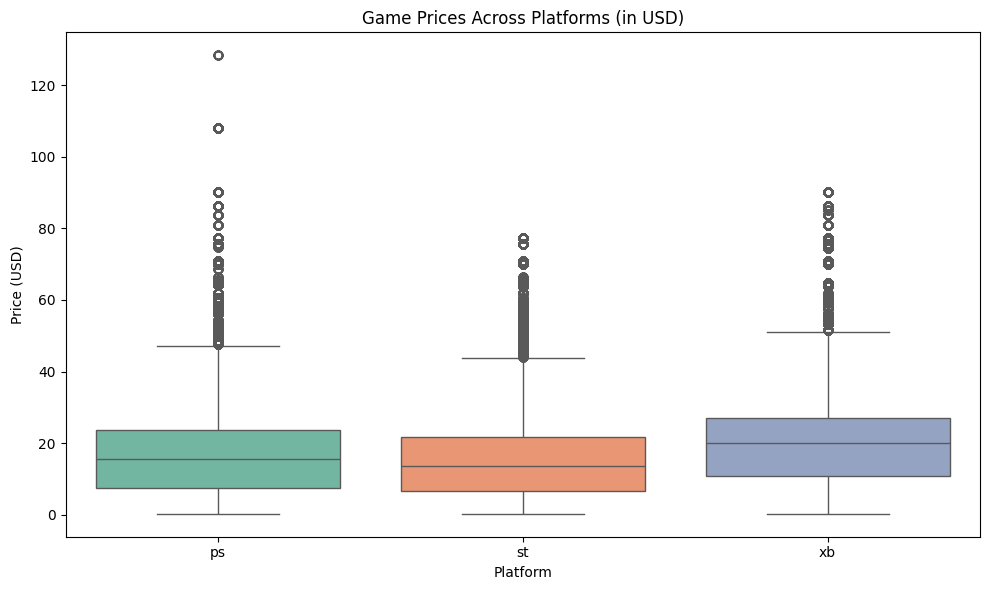

In [76]:
### Boxplot visualizing the distribution of game prices (in USD) across platforms

# Convert prices to USD
exchange_rates = {
    'eur': 1.08, 
    'gbp': 1.29, 
    'jpy': 0.0067,
    'rub': 0.012, 
    'usd': 1.0
}

tidy_game_info['price_usd'] = tidy_game_info.apply(
    lambda row: row['price'] * exchange_rates.get(row['currency'].lower(), 1.0), axis=1
)

# Visualize price distribution across platforms
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='price_usd', hue='platform', data=tidy_game_info, palette='Set2', legend=False)

plt.title("Game Prices Across Platforms (in USD)")
plt.xlabel("Platform")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

### Number of Achievements Distribution of Shared Games Across Platforms

Interpretation:
- The number of achievements per game typically stays below 50, with a few outliers over 100.
- Games on PlayStation generally feature more achievements than games on other platforms, while games on Steam have a wider range with outliers reaching over 1000.

count    10398.000000
mean        41.527890
std         61.519762
min          0.000000
25%         19.000000
50%         31.000000
75%         50.000000
max       4820.000000
Name: achievements_per_game, dtype: float64


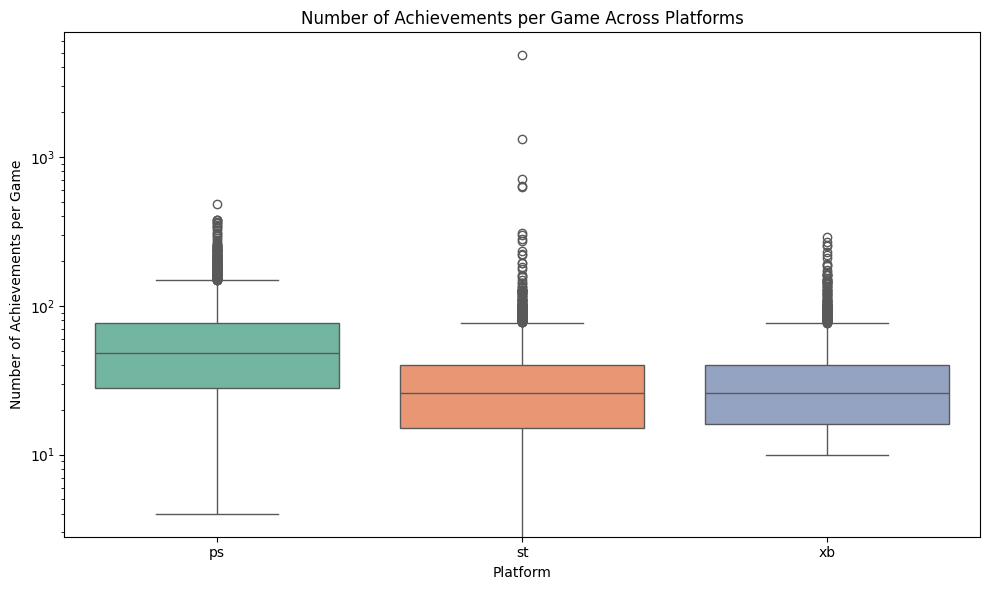

In [77]:
### Boxplot visualizing the distribution of the number of achievements per game across platform

achievements_per_game = tidy_game_info.groupby(["title", "platform"])["achievementid"].nunique().reset_index()
achievements_per_game.rename(columns={"achievementid": "achievements_per_game"}, inplace=True)

print(achievements_per_game['achievements_per_game'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='achievements_per_game', hue='platform', data=achievements_per_game, palette='Set2', legend=False)

plt.title("Number of Achievements per Game Across Platforms")
plt.xlabel("Platform")
plt.ylabel("Number of Achievements per Game")
plt.yscale('log')
plt.tight_layout()
plt.show()

### Distribution of Top 10 Popular Genre Tags of Shared Games Across Platforms

Interpretation: 
- The Top 10 most commonly assigned genres for shared games across platforms are Indie, Adventure, Action, RPG, Simulation, Strategy, Platformer, Casual, Turn-Based, and Puzzle.
- Steam has the highest frequency of Top 10 genre tags assigned to shared games compared to PlayStation and Xbox, indicating that a larger proportion of games on Steam might be categorized with certain genres.

platform          ps         st        xb
genres                                   
Indie       7.111988  21.286433  5.377374
Adventure   7.651840  15.989195  9.944078
Action      3.637378  21.155339  7.477222
RPG         7.748229   7.982374  7.204869
Simulation  3.650442   7.894061  4.251958
Strategy    3.224986   6.535450  3.247911
Platformer  7.419870   0.000000  4.897708
Casual      0.308587   9.025932  0.375719
Turn Based  4.603744   0.000000  4.152657
Puzzle      4.182173   0.000000  3.135834


<Figure size 1200x800 with 0 Axes>

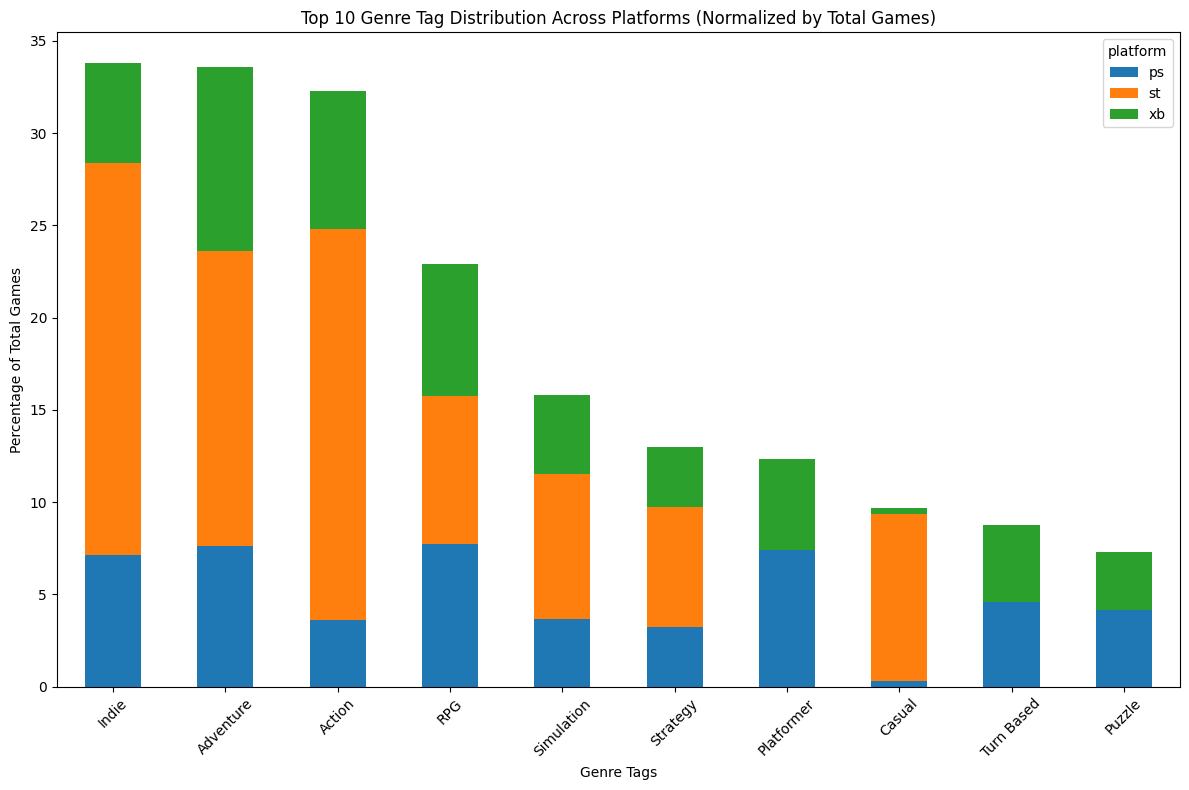

In [78]:
### Stacked barplot visualizing the distribution of the top 10 genre tags across different platforms

# Clean and explode genres into separate rows
tidy_game_info['genres'] = tidy_game_info['genres'].apply(lambda x: x.strip("[]").replace("'", '').split(', ') if isinstance(x, str) else x)
tidy_game_info = tidy_game_info.explode('genres')  

# Replace 'Role Playing' genre with 'RPG' genre
tidy_game_info['genres'] = tidy_game_info['genres'].replace({'Role Playing': 'RPG'})

# Normalize genre counts by the total number of games on each platform
total_games_per_platform = tidy_game_info['platform'].value_counts()
genre_counts_per_platform = tidy_game_info.groupby(['platform', 'genres']).size().reset_index(name='count')
genre_counts_per_platform['percentage'] = genre_counts_per_platform.apply(
    lambda row: row['count'] / total_games_per_platform[row['platform']] * 100, axis=1
)

# Select top 10 genres
top_10_genres = genre_counts_per_platform.groupby('genres')['percentage'].sum().sort_values(ascending=False).head(10).index
top_10_genre_data = genre_counts_per_platform[genre_counts_per_platform['genres'].isin(top_10_genres)]

# Pivot the data to prepare for stacking by platform with genres on the x-axis
top_10_genre_data_pivot = top_10_genre_data.pivot_table(
    index='genres', columns='platform', values='percentage', aggfunc='sum', fill_value=0
)
top_10_genre_data_pivot = top_10_genre_data_pivot.loc[top_10_genres]
print(top_10_genre_data_pivot)


plt.figure(figsize=(12, 8))
top_10_genre_data_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Top 10 Genre Tag Distribution Across Platforms (Normalized by Total Games)')
plt.xlabel('Genre Tags')
plt.ylabel('Percentage of Total Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# SI 618 WN Project Part II

## Descriptive Statistics
> Provide a comprehensive summary of your combined dataset using descriptive statistics. This should include means, medians, modes, ranges, variance, and standard deviations for the relevant features of your data.  The descriptive statistics should inform your guiding questions that you developed in Part I of the project, rather than merely providing an overview of your data.  Interpret these results to draw preliminary conclusions about the data.

### Summary
This analysis explores the distribution strategies of games and player behaviors across three platforms by transforming categorical variables into cardinality measures (count-based representations). The goal is to understand game attributes (e.g., price, achievements, supported languages) and player engagement (e.g., game ownership and achievement unlocks) on different platforms, and the findings align with common perceptions of these platforms.

### Games Cardinality Analysis

Interpretations:
1. **Pricing (usd)**: **Steam** has the widest range of prices (min: $0.49, max: $199.99, mean: $9.68), with a higher standard deviation, suggesting a mix of cheap indie games and premium titles. **PlayStation** has slightly higher average prices ($12.44) but a smaller price range ($0.19 - $99.99). **Xbox** has a similar average price ($9.72) but a significantly smaller sample size (294 games).

2. **Number of Achievements**: **Steam** achievements are highly variable, with the highest average number of achievements (38.36), likely due to an open publishing system where developers set their own achievement numbers. **PlayStation** (27 on average) and **Xbox** (31 on average) have more standardized achievement systems.

3. **Number of Supported Languages**: **Steam** has the best multilingual support, it supports the most languages on average (6.51), with some games supporting up to 103 languages, probably due to its international reach and flexibility for indie developers to add translations. **PlayStation** games support 7.1 languages on average, but with a much lower max (29). **Xbox** games tend to have more limited language support.

4. **Number of Genre Tags**: **Steam** games have the highest variety in genre tags (2.88 on average, max 16), indicating more diverse game categories. **Xbox** follows with 2.21, suggesting a bit more variety. **PlayStation** has the least variety (1.28 on average, max 7), meaning games are more likely to fall into one main genre. 

In [79]:
### Games on different platforms

def count_elements_from_string(x):
    """
    Cleans a string representation of a list (removes brackets, quotes) and splits by commas to count the elements.
    """
    if isinstance(x, str) and pd.notna(x):
        return len(x.strip("[]").replace("'", '').split(', '))
    return np.nan

def cardinality_process(game_info, achievements):
    """
    Processes platform-specific game data to count the number of achievements, supported languages, and genre tags per game.
    Returns a new DataFrame without modifying the original data.
    """
    # Step 1: Create a copy of the input DataFrames to avoid modifying the originals
    game_info_copy = game_info.copy()
    achievements_copy = achievements.copy()
    
    # Step 2: Get the number of achievements per game
    num_achievements = achievements_copy.groupby('gameid').size().reset_index(name='num_of_achievements')
    
    # Step 3: Merge the achievement data with the game info and remove unnecessary columns
    columns_to_drop = ['achievementid', 'achievement_title', 'achievement_description', 'rarity', 'eur', 'gbp', 'jpy', 'rub']
    game_data = game_info_copy.merge(num_achievements, on='gameid', how='left')
    game_data = game_data.drop([col for col in columns_to_drop if col in game_data.columns], axis=1)
    
    # Step 4: Drop duplicates
    game_data = game_data.drop_duplicates()
    
    # Step 5: Apply the helper function to count supported languages and genre tags
    game_data['num_of_supported_languages'] = game_data['supported_languages'].apply(count_elements_from_string)
    game_data['num_of_genre_tags'] = game_data['genres'].apply(count_elements_from_string)
    
    return game_data

ps_games_cardinality = cardinality_process(ps_game_info, ps_achievements)
st_games_cardinality = cardinality_process(st_game_info, steam_achievements)
xb_games_cardinality = cardinality_process(xb_game_info, xbox_achievements)

games_dict = {
    "PlayStation": ps_games_cardinality,
    "Steam": st_games_cardinality,
    "Xbox": xb_games_cardinality,
}

for key, games in games_dict.items():
    games['gameid'] = games['gameid'].astype('str')
    print(f'{key}:\n {games.describe()}\n')

PlayStation:
                 usd  num_of_achievements  num_of_supported_languages  \
count  20193.000000         23151.000000                10614.000000   
mean      12.438703            27.081249                    7.098926   
std       12.006371            17.518223                    4.997843   
min        0.190000             3.000000                    1.000000   
25%        4.490000            13.000000                    4.000000   
50%        7.990000            21.000000                    6.000000   
75%       18.990000            36.000000                   10.000000   
max       99.990000           411.000000                   29.000000   

       num_of_genre_tags  
count       23009.000000  
mean            1.279195  
std             0.557789  
min             1.000000  
25%             1.000000  
50%             1.000000  
75%             1.000000  
max             7.000000  

Steam:
                 usd  num_of_achievements  num_of_supported_languages  \
count  77874.

In [80]:
# columns_to_plot = ['usd', 'num_of_achievements', 'num_of_supported_languages', 'num_of_genre_tags']

# for key, games in games_dict.items():
#     pairplot = sns.pairplot(games[columns_to_plot], plot_kws={'alpha': 0.7}, height=2.5, diag_kind='kde')
#     pairplot.fig.suptitle(f"{key} Platform Games Pairplot", size=16)
    
#     plt.subplots_adjust(top=0.95)
#     plt.show()

### Players Cardinality Analysis

Interpretations:
1. **Number of Games Owned**
- **Steam**: Players on Steam own fewer games on average (mean = 57.06), with a wide range (min = 1, max = 1252). The distribution is highly right-skewed, as indicated by the large standard deviation (std = 83.49) and the median of 29.
- **PlayStation**: Players on PlayStation tend to own more games on average (mean = 199.02), with the range extending from 1 to 5963 games. The distribution is also right-skewed, as evidenced by the median of 129 being lower than the mean and the high standard deviation (std = 258.15).
- **Xbox**: Xbox players have an average of 202.81 games owned, similar to PlayStation. However, Xbox has a wider range, with players owning from 1 to 5945 games. The distribution follows the same pattern as PlayStation, with a high standard deviation (std = 326.74) and the median (121) being lower than the mean.

2. **Number of Achievements Unlocked**
- **Steam**: The average number of achievements unlocked on Steam is 2210.39, with a very large standard deviation (std = 13161.10), indicating a wide range of player engagement. The distribution is highly right-skewed, as seen with the median of 455 being much lower than the mean, and the maximum of 545,949 achievements unlocked by a few players.
- **PlayStation**: PlayStation players unlock an average of 3902 achievements, with a similarly high standard deviation (std = 5954.56). The distribution is right-skewed, as shown by the median of 2048 being lower than the mean, with a maximum of 157,477 achievements.
- **Xbox**: Xbox players have a mean of 3064.99 achievements unlocked, with a large standard deviation (std = 6347.31), suggesting variability in player engagement. The median of 1443 is lower than the mean, and the maximum of 89,780 achievements indicates a few highly engaged players.

Summary:
- PlayStation and Xbox show higher levels of engagement, with more games owned and more achievements unlocked on average compared to Steam.
- Steam players generally own fewer games and unlock fewer achievements, but there is still substantial variation across players.
- All three platforms exhibit right-skewed distributions, where most players engage moderately, and a few highly active players drive up the averages.

In [81]:
### Active Players on different platforms

def player_cardinality_process(players):
    """
    Aggregates player data to count the number of games owned and achievements unlocked.
    """
    players_copy = players.copy()

    # Step 1: Count unique games per player and number of achievements unlocked per player
    player_data = players_copy.groupby('playerid').agg(
        num_games_owned=('gameid', 'nunique'),  # Count unique games per player
        num_achievements_unlocked=('achievementid', 'count')  # Count total achievements unlocked per player
    ).reset_index()

    # Step 4:  Filter out inactive players (those with 0 games owned) and drop duplicates
    player_data = player_data[player_data['num_games_owned'] > 0]
    player_data = player_data.drop_duplicates()

    return player_data

ps_players_cardinality = player_cardinality_process(ps_player_info)
st_players_cardinality = player_cardinality_process(st_player_info)
xb_players_cardinality = player_cardinality_process(xb_player_info)

players_dict = {
    "PlayStation": ps_players_cardinality,
    "Steam": st_players_cardinality,
    "Xbox": xb_players_cardinality,
}

for key, players in players_dict.items():
    players['playerid'] = players['playerid'].astype("str")
    print(f'{key}:\n {players.describe()}\n')

PlayStation:
        num_games_owned  num_achievements_unlocked
count      5000.000000                5000.000000
mean        199.015800                3902.016600
std         258.146649                5954.557504
min           1.000000                   1.000000
25%          66.000000                 882.750000
50%         129.000000                2048.000000
75%         242.000000                4772.250000
max        5963.000000              157477.000000

Steam:
        num_games_owned  num_achievements_unlocked
count      4838.000000                4838.000000
mean         57.055808                2210.392518
std          83.492552               13161.102483
min           1.000000                   1.000000
25%          11.000000                 133.000000
50%          29.000000                 455.000000
75%          69.000000                1461.750000
max        1252.000000              545949.000000

Xbox:
        num_games_owned  num_achievements_unlocked
count      4984.000

## Inferential statistics
> Conduct appropriate _hypothesis tests_ to investigate if there are significant differences or correlations within your data.  This might involve regression analysis, ANOVA, and/or chi-squared tests.
Clearly state your null and alternative hypotheses, choose an appropriate significance level, and discuss your findings. Make sure to justify the choice of your tests.

In [82]:
for col in tidy_game_info.columns:
    unique_values = tidy_game_info[col].nunique()
    total_rows = len(tidy_game_info)
    
    print(f"{col}: {unique_values}/{total_rows} unique values")
    
    if unique_values == total_rows:
        print(f"{col} is a unique identifier\n")

gameid: 14839/3913375 unique values
title: 3466/3913375 unique values
developers: 3427/3913375 unique values
publishers: 2430/3913375 unique values
genres: 112/3913375 unique values
supported_languages: 3071/3913375 unique values
release_date: 2570/3913375 unique values
achievementid: 431807/3913375 unique values
achievement_title: 114017/3913375 unique values
achievement_description: 153785/3913375 unique values
platform: 3/3913375 unique values
currency: 5/3913375 unique values
price: 1580/3913375 unique values
price_usd: 2062/3913375 unique values


In [83]:
tidy_game_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3913375 entries, 0 to 2159924
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  platform                 object 
 11  currency                 object 
 12  price                    float64
 13  price_usd                float64
dtypes: float64(2), int64(1), object(11)
memory usage: 447.9+ MB


In [84]:
ps_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19861683 entries, 0 to 19861682
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   country        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   rarity         object 
 9   library        object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.5+ GB


In [85]:
st_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113724 entries, 0 to 11113723
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   country        object 
 2   created        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   library        object 
dtypes: float64(1), int64(1), object(7)
memory usage: 763.1+ MB


In [86]:
xb_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15545366 entries, 0 to 15545365
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   achievementid  object 
 3   date_acquired  object 
 4   gameid         float64
 5   title          object 
 6   description    object 
 7   points         float64
 8   library        object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ GB


### 1. Are games with more achievements associated with higher price?
Since we are only testing whether a relationship between number of achievements and price in USD exists, **Pearson’s correlation** is appropriate.
Here are the justifications:
- Both variables are continuous (necessary for Pearson’s correlation).
- We wanted to test for linear associations rather than predictive modeling (which would require regression).
- Significance level evaluation (p-value) helps determine if observed correlations are likely due to chance.

#### Null Hypothesis (H0)
There is no significant correlation between the number of achievements and game price.

#### Alternative Hypothesis (HA)
There is a significant correlation between the number of achievements and game price.


In [87]:
import statsmodels.api as sm

achievement_counts = tidy_game_info.groupby(['gameid', 'platform'])['achievementid'].count().reset_index()
achievement_counts.rename(columns={'achievementid': 'num_achievements'}, inplace=True)

game_price_data = tidy_game_info[['gameid', 'platform', 'price_usd']].drop_duplicates()
df_p_a = pd.merge(achievement_counts, game_price_data, on=['gameid', 'platform'])

In [88]:
achievement_counts

,gameid,platform,num_achievements
0,51,ps,255
1,55,ps,455
2,67,ps,245
3,81,ps,60
4,84,ps,60
...,...,...,...
14847,3135560,st,0
14848,3143880,st,1005
14849,3165620,st,555
14850,3221740,st,210


In [89]:
tidy_game_info[tidy_game_info['gameid']==51].duplicated().sum()

np.int64(0)

In [90]:
df_p_a.dropna(subset=['price_usd', 'num_achievements'], inplace=True)

In [91]:
from scipy.stats import pearsonr

def compute_pearson(df, platform):
    subset = df[df['platform'] == platform].dropna(subset=['num_achievements', 'price_usd'])
    
    r, p_value = pearsonr(subset['num_achievements'], subset['price_usd'])
    return platform, r, p_value

platforms = df_p_a['platform'].unique()
results = [compute_pearson(df_p_a, platform) for platform in platforms]

pearson_results = pd.DataFrame(results, columns=['Platform', 'Correlation (r)', 'p-value'])
pearson_results

,Platform,Correlation (r),p-value
0,ps,0.428426,0.000000e+00
1,xb,0.382704,0.000000e+00
2,st,0.115512,1.609254e-49


In [92]:
def interpret_pearson_results(df):

    interpretations = []
    
    for _, row in df.iterrows():
        platform = row["Platform"]
        r = row["Correlation (r)"]
        p = row["p-value"]
        
        # alpha: significance level
        if p < 0.01:
            significance = "highly significant (p < 0.01)"
        elif p < 0.05:
            significance = "significant (p < 0.05)"
        else:
            significance = "not significant (p >= 0.05)"
        
        # r: strength and direction of correlation
        r_abs = abs(r)
        if r_abs >= 0.7:
            strength = "a strong correlation"
        elif r_abs >= 0.4:
            strength = "a moderate correlation"
        elif r_abs >= 0.2:
            strength = "a weak correlation"
        else:
            strength = "no meaningful correlation"

        if r > 0:
            direction = "positive (more achievements is associated with higher price)"
        elif r < 0:
            direction = "negative (more achievements is associated with lower price)"
        else:
            direction = "no correlation at all"

        interpretation = f"On {platform} platform, there is {strength} ({direction}), and the result is {significance} (r = {r:.2f}, p = {p:.3f}).\n"
        interpretations.append(interpretation)
    
    return "\n".join(interpretations)

interpretation_text = interpret_pearson_results(pearson_results)
print(interpretation_text)

On ps platform, there is a moderate correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.43, p = 0.000).

On xb platform, there is a weak correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.38, p = 0.000).

On st platform, there is no meaningful correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.12, p = 0.000).



#### Interpretation
- PlayStation Platform: Moderate positive correlation (r = 0.43), highly significant (p < 0.01) → Reject H_0  → More achievements are moderately associated with higher price.
- Xbox Platform: Weak positive correlation (r = 0.38), highly significant (p < 0.01) → Reject H_0  → More achievements are weakly associated with higher price.
- Steam Platform: No meaningful correlation (r = 0.12), highly significant (p < 0.01) → Reject H_0  → Although significant, the correlation is too weak to suggest a strong association.

On PlayStation and Xbox, a higher number of achievements tends to be associated with higher prices, though the relationship is stronger on PS. On Steam, while significant, the association is too weak to be practically meaningful.

### 2. PlayStation and Steam: Do players from different countries tend to complete achievements faster?
#### Test used: One-Way ANOVA
* y: achievement completion time (time_to_achievement = date_acquired - release_date).
* X: country (in merged_player_info).
* Condition: ANOVA assumes normally distributed residuals and equal variances. If these assumptions don’t hold, we may use a Kruskal-Wallis test (non-parametric alternative).

#### Null Hypothesis (H0)
There is no significant difference in achievement completion time among players from different countries.

#### Alternative Hypothesis (HA)
At least one country's players complete achievements at a significantly different speed compared to others.

#### Necessary merging for player-focus info

In [93]:
# standardizing data
ps_player_info["player_platform"] = "ps"
ps_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
ps_player_info.drop(columns=["rarity", "nickname", "library"], axis=1, inplace=True)

In [94]:
ps_player_info.sample(5)

,playerid,country,achievementid,date_acquired,gameid,achievement_title,description,player_platform
16476228,168318,United States,3798_55200,2013-01-29 23:40:04,3798.0,Inked Up,Earn 5 skill tattoos.,ps
12728726,2726416,United States,463359_4169323,2022-08-07 12:17:07,463359.0,Boss Dancer III,Beat the boss of level 3,ps
19353384,3168781,United Kingdom,NaN,NaN,NaN,NaN,NaN,ps
18915042,2004150,France,458481_4114341,2023-02-06 15:07:56,458481.0,Stacked Deck,Play 25 cards in a single match.,ps
9978391,4619978,United States,439989_3982819,2021-07-06 04:05:26,439989.0,Commanding Respect,Received 100 gifts from demons.,ps


In [95]:
st_player_info["player_platform"] = "st"
st_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
st_player_info.drop(columns=["created", "library"], inplace=True)

In [96]:
st_player_info.sample(5)

,playerid,country,achievementid,date_acquired,gameid,achievement_title,description,player_platform
8717914,76561198067248833,Poland,326460_mis_win15,2017-05-11 00:02:41,326460.0,Following Orders,Complete 15 missions,st
10209069,76561197997616073,NaN,1250_WinFoundryNormal,2017-10-23 03:02:35,1250.0,Tin Man,"Win a Long Game on Foundry, on Normal Difficulty.",st
5008139,76561198314830742,Russian Federation,781760_NEW_ACHIEVEMENT_2_6,2018-11-23 00:22:43,781760.0,Super Trivia Champion,Super Trivia Champion,st
6484736,76561198169892406,Chad,1454400_185,2024-10-11 20:05:33,1454400.0,Magic kingdom,Have 200 wizard towers.,st
5003750,76561198314830742,Russian Federation,645090_1555,2017-08-11 11:16:40,645090.0,💣!,Pass the level 💣!,st


In [97]:
xb_player_info["player_platform"] = "xb"
xb_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
xb_player_info.drop(columns=["points", "nickname", "library"], inplace=True)

xb_player_info["country"] = 'Unknown'

In [98]:
xb_player_info.sample(5)

,playerid,achievementid,date_acquired,gameid,achievement_title,description,player_platform,country
11377366,724930,NaN,NaN,NaN,NaN,NaN,xb,Unknown
6534783,2860965,19170_396640,2022-03-16 01:10:17,19170.0,So I Got That Going for Me,Lead a Caravan containing at least 5 Llamas,xb,Unknown
6324997,835431,7545_353375,2018-05-04 00:54:06,7545.0,Put Up Your Dukes,Halo 2A MP: Get 25 melee kills in multiplayer.,xb,Unknown
934163,848525,139186_2360212,2019-01-06 03:08:24,139186.0,Freud in training,Got your first match in a solo game,xb,Unknown
8151976,825864,8901_359060,2015-12-12 03:09:27,8901.0,High Tide,"Complete In Darkness on Hardened, Veteran, or ...",xb,Unknown


In [99]:
for df, name in zip([ps_player_info, st_player_info, xb_player_info], ["PS", "ST", "XB"]):
    duplicates = df.duplicated(subset=["playerid", "gameid", "achievementid"], keep=False).sum()
    print(f"{name}: {duplicates} potential duplicate entries on (playerid, gameid, achievementid).")

PS: 0 potential duplicate entries on (playerid, gameid, achievementid).
ST: 0 potential duplicate entries on (playerid, gameid, achievementid).
XB: 0 potential duplicate entries on (playerid, gameid, achievementid).


In [100]:
columns_order = [
    "playerid", "country", "player_platform", "achievementid",
    "date_acquired", "gameid", "achievement_title", "description"
]

ps_player_info = ps_player_info[columns_order]
st_player_info = st_player_info[columns_order]
xb_player_info = xb_player_info[columns_order]

In [101]:
merged_player_info = pd.concat([ps_player_info, st_player_info, xb_player_info], ignore_index=True)

In [102]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
706206,303626,Spain,ps,203_3040,2011-06-13 02:09:54,203.0,With My Devil Dogs,"(Online) Use Squad in the menu, find a friend ..."
39106350,811570,Unknown,xb,1237_278562,2013-08-08 13:01:57,1237.0,The Merchant of Venice,Complete DNA Sequence 7.
21175902,76561198298591193,Germany,st,851710_NEW_ACHIEVEMENT_196_28,2018-05-06 00:35:33,851710.0,Super Trivia Champion,Super Trivia Champion
23694658,76561198280871241,Japan,st,440730_KILLS_31_15,2018-07-28 20:36:34,440730.0,The Bozz,sweetboy
18746293,386959,United States,ps,15318_157389,2016-12-08 06:30:30,15318.0,Photo Rookie,Improved photography level for the first time.


In [103]:
merged_player_info['date_acquired'] = merged_player_info['date_acquired'].str[:10]

In [104]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
12061284,372418,Japan,ps,653_6622,2016-12-30,653.0,Persian History X,Kill the Persian King
2840525,400158,Brazil,ps,10749_123211,2015-12-14,10749.0,"""Gonk? Gonk!""",Capture three droids in a match of Droid Run
29553619,76561198014962659,Czechia,st,748300_ACH_SELL_ONE,2022-03-27,748300.0,Digging Gold,Sell your first item.
43099509,639220,Unknown,xb,407383_3797867,2020-12-01,407383.0,Calling It In,Get 50 kills with lethal Scorestreaks in Multi...
525891,330740,United Kingdom,ps,7185_88028,2017-08-28,7185.0,She's Ready,Complete the story of inFAMOUS First Light™


In [105]:
# print(f"Merged dataset shape: {merged_player_info.shape}")
# print(f"Merged dataset duplicates: {merged_player_info.duplicated().sum()}")
# print(merged_player_info.info())

#### ANOVA

In [106]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
12082647,77797,France,ps,375_18118,2011-09-22,375.0,The rainy side of the street,Win a race with wet weather in any game mode.
44792831,1349649,Unknown,xb,1433_273605,2017-05-07,1433.0,Napalm in the Morning,You have won a battle!
19553527,2041803,Brazil,ps,7355_90160,2017-12-30,7355.0,Stuntman,Successfully perform an action hijack.
34475683,848352,Unknown,xb,21167_402493,2018-09-04,21167.0,Two out of Three,Won a game of Rock/Paper/Scissors.
13736946,410896,United Kingdom,ps,10638_122470,2015-11-26,10638.0,Gun-For-Hire,Complete 10 Side Quests


In [107]:
mp_filtered = merged_player_info[['playerid', 'country', 'date_acquired', 'gameid', 'player_platform']]
tg_filtered = tidy_game_info[['gameid', 'release_date']]

In [108]:
mp_filtered['date_acquired'].sample(10)

20494247    2018-06-04
17829719    2022-07-19
29710949    2019-11-28
31510241    2014-07-18
25688214    2019-05-08
21011336    2018-02-22
9841237     2010-12-09
29426433           NaN
25800621    2018-09-28
45459672    2012-10-13
Name: date_acquired, dtype: object

In [109]:
mp_filtered = mp_filtered[mp_filtered['player_platform'].isin(['ps', 'st'])]
mp_filtered.loc[:, 'date_acquired'] = pd.to_datetime(mp_filtered['date_acquired'], errors='coerce')
tg_filtered.loc[:, 'release_date'] = pd.to_datetime(tg_filtered['release_date'], errors='coerce')

In [110]:
game_release_dict = tg_filtered.set_index('gameid')['release_date'].to_dict()
mp_filtered['release_date'] = mp_filtered['gameid'].map(game_release_dict)

mp_filtered['date_acquired'] = pd.to_datetime(mp_filtered['date_acquired'])
mp_filtered['release_date'] = pd.to_datetime(mp_filtered['release_date'])

mp_filtered['time_to_achievement'] = (mp_filtered['date_acquired'] - mp_filtered['release_date']).dt.days

# remove invalid/negative completion times
mp_filtered = mp_filtered[(mp_filtered['time_to_achievement'] >= 0) & (mp_filtered['time_to_achievement'].notna())]

# filter countries with at least 100 players for meaningful analysis
country_counts = mp_filtered['country'].value_counts()
mp_filtered = mp_filtered[mp_filtered['country'].isin(country_counts[country_counts >= 100].index)]

In [111]:
from scipy import stats

# check for normality
# sample 5000 rows for normality test (Shapiro-Wilk does not work well on very large data)
sample_df = mp_filtered.sample(n=min(5000, len(mp_filtered)), random_state=42)

stat, p = stats.shapiro(sample_df['time_to_achievement'])
print(f"Shapiro-Wilk Test: p-value = {p:.4f}")

if p < 0.05:
    print("Time-to-achievement is NOT normally distributed.")
else:
    print("Time-to-achievement appears normally distributed.")


Shapiro-Wilk Test: p-value = 0.0000
Time-to-achievement is NOT normally distributed.


In [112]:
# Levene’s test for equal variances across countries
stat, p = stats.levene(*[mp_filtered[mp_filtered['country'] == c]['time_to_achievement'] for c in mp_filtered['country'].unique()])
print(f"Levene's Test: p-value = {p:.4f}")

if p < 0.05:
    print("Variances are NOT equal (consider Welch's ANOVA).")
else:
    print("Variances are approximately equal (proceed with standard ANOVA).")


Levene's Test: p-value = 0.0000
Variances are NOT equal (consider Welch's ANOVA).


#### Since both assumptions for ANOVA are violated (not normally distributed nor equal variance), we choose to run **Kruskal-Wallis (one-way ANOVA on ranks)** instead.

In [113]:
kruskal_result = stats.kruskal(*[mp_filtered[mp_filtered['country'] == c]['time_to_achievement'] for c in mp_filtered['country'].unique()])
print(f"Kruskal-Wallis Test: H-statistic = {kruskal_result.statistic:.4f}, p-value = {kruskal_result.pvalue:.4f}")

if kruskal_result.pvalue < 0.05:
    print("Reject H0: There is a significant difference in achievement completion time across countries (non-parametric).")
else:
    print("Fail to reject H0: No significant difference in completion time across countries.")

Kruskal-Wallis Test: H-statistic = 331601.9087, p-value = 0.0000
Reject H0: There is a significant difference in achievement completion time across countries (non-parametric).


#### Interpretation of Kruskal-Wallis (one-way ANOVA on ranks) results

We conducted a **Kruskal-Wallis test**, a non-parametric alternative to ANOVA, due to violations of normality and/or equal variance assumptions.  

- H-statistic = 331601.9087, **p-value = 0.0000**  
- Since **p < 0.05**, we **reject the null hypothesis (H_0)**.  
- This result indicates a **statistically significant difference** in **achievement completion times across countries** on **PlayStation and Steam** platforms.  

### 3. Do games with more supported languages attract more players? [related to graphical analysis #4] 
We will conduct a **linear regression analysis** to determine whether the number of supported languages influences the number of players who purchased a game.
* The dependent variable (num_players_purchased) is continuous.
* The independent variable (num_supported_languages) is continuous.
* OLS regression helps quantify the strength and significance of the relationship.

#### Null Hypothesis:
The number of supported languages in a game does not significantly predict the number of players who purchased it.

#### Alternative Hypothesis:
The number of supported languages in a game significantly influences the number of players who purchased it.

In [114]:
lst = tidy_game_info['supported_languages'].sample()

In [115]:
lst.iloc[0]

"['English', 'French', 'German', 'Spanish - Spain', 'Russian', 'Japanese', 'Korean', 'Portuguese - Portugal', 'Portuguese - Brazil', 'Simplified Chinese', 'Italian']"

In [116]:
import ast

game_data = tidy_game_info[['gameid', 'supported_languages']].copy()

# convert string-formatted lists to actual lists and count the number of languages
game_data['num_languages'] = game_data['supported_languages'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0)

# keep only numeric values
game_data.drop(columns=['supported_languages'], inplace=True)

In [117]:
game_data.sample(5)

,gameid,num_languages
1999616,218620,12
1470102,464113,0
457249,592315,14
1474576,453073,5
2139863,516787,0


In [118]:
# unique players per game
player_counts = merged_player_info.groupby('gameid')['playerid'].nunique().reset_index()
player_counts.rename(columns={'playerid': 'num_players'}, inplace=True)

df_regression = game_data.merge(player_counts, on='gameid', how='inner')

In [119]:
df_regression.sample(5)

,gameid,num_languages,num_players
185787,417403,15,729
781537,447150,10,209
1236129,558555,10,172
2999118,523592,0,13
557259,605543,0,1


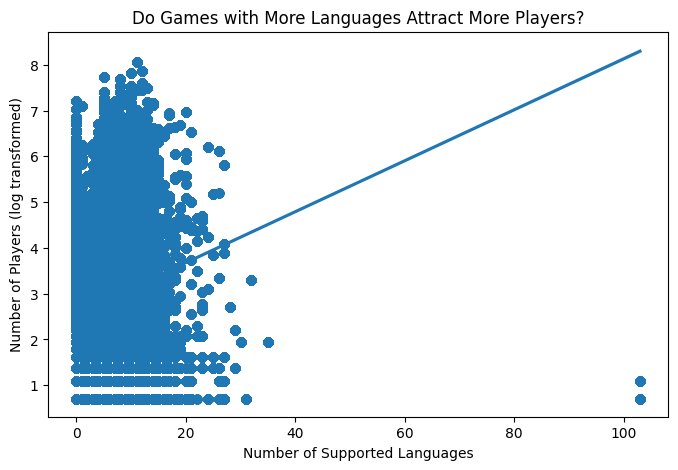

In [120]:
df_regression['log_num_players'] = np.log1p(df_regression['num_players'])


plt.figure(figsize=(8,5))
sns.regplot(x=df_regression['num_languages'], y=df_regression['log_num_players'])
plt.xlabel("Number of Supported Languages")
plt.ylabel("Number of Players (log transformed)")
plt.title("Do Games with More Languages Attract More Players?")
plt.show()

#### Since the scatterplot does not suggest a strong linear relationship between the number of supported languages and the number of players, we decided to switch to bin the number of supported languages and evaluate the binned variable and the number of players again.

/var/folders/sd/5vy204s55_ggyjh65z1tlxg00000gn/T/ipykernel_50638/145610165.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_regression.groupby('language_bins')['num_players'].mean().plot(kind="bar")


<Axes: xlabel='language_bins'>

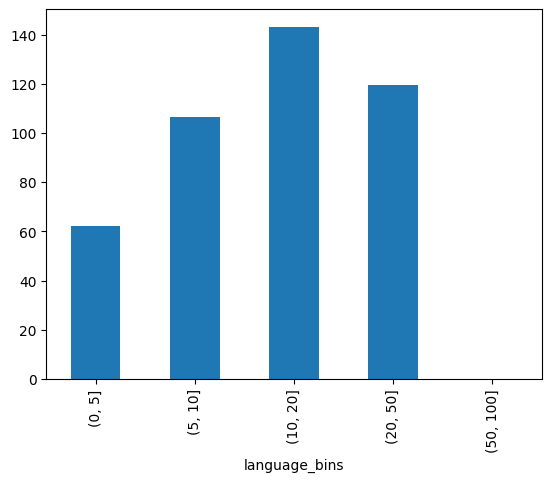

In [121]:
df_regression['language_bins'] = pd.cut(df_regression['num_languages'], bins=[0, 5, 10, 20, 50, 100])
df_regression.groupby('language_bins')['num_players'].mean().plot(kind="bar")

#### This visualization leads us to use ANOVA to test the statistical significance between bins of supported languages.

In [122]:
from scipy.stats import f_oneway

# only non-empty bins are included
groups = [df_regression[df_regression['language_bins'] == b]['num_players'].dropna() 
          for b in df_regression['language_bins'].unique() 
          if len(df_regression[df_regression['language_bins'] == b]) > 0]

if len(groups) > 1:  # at least two groups
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA Test: F = {f_stat:.4f}, p = {p_val:.4f}")
else:
    print("ANOVA cannot be performed: Not enough non-empty groups.")


ANOVA Test: F = 10413.1380, p = 0.0000


#### Interpretation of ANOVA Results: Number of Supported Languages vs. Player Count

- F-statistic = 10413.1380, **p-value = 0.0000**  
- Since **p < 0.05**, we **reject the null hypothesis (H_0)**.  
- This indicates a **statistically significant difference** in the **number of players across language support bins**.  

### 4. Do expensive vs. cheap games have different likelihoods of being cross-platform?
#### Variables and groups
* price category (high/low) vs. single vs. multi-platform.

#### Test Used: Chi-Square Test of Independence
* Both variables are categorical, and we want to test for association.

#### Null Hypothesis
There is no significant association between a game’s price category (high/low) and whether it is single-platform or multi-platform.

#### Alternative Hypothesis
There is a significant association between a game’s price category and its likelihood of being cross-platform.

In [123]:
tidy_game_info.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'platform', 'currency',
       'price', 'price_usd'],
      dtype='object')

In [124]:
from scipy.stats import chi2_contingency

df_price_platform = tidy_game_info[['title', 'price_usd', 'platform']].dropna(subset=['price_usd', 'platform']).drop_duplicates()

# price categories based on median price
median_price = df_price_platform['price_usd'].median()
df_price_platform['price_category'] = np.where(df_price_platform['price_usd'] <= median_price, 'Cheap', 'Expensive')

In [125]:
df_price_platform.duplicated().sum()

np.int64(0)

In [126]:
# classify: single-platform or cross-platform
platform_counts = df_price_platform.groupby('title')['platform'].nunique().reset_index()
platform_counts.rename(columns={'platform': 'num_platforms'}, inplace=True)

df_price_platform = df_price_platform.merge(platform_counts, on='title', how='left')

df_price_platform['platform_type'] = np.where(df_price_platform['num_platforms'] > 1, 'Multi-Platform', 'Single-Platform')

print(df_price_platform['num_platforms'].value_counts())


num_platforms
3    39144
2     1491
1      232
Name: count, dtype: int64


In [127]:
contingency_table = pd.crosstab(df_price_platform['price_category'], df_price_platform['platform_type'])

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test: χ² = {chi2_stat:.4f}, p-value = {p_val:.4f}")

if p_val < 0.05:
    print("Reject H0: There is a significant association between game price category and platform availability.")
else:
    print("Fail to reject H0: No significant association between game price category and platform availability.")

Chi-Square Test: χ² = 3.9091, p-value = 0.0480
Reject H0: There is a significant association between game price category and platform availability.


#### Interpretation of Chi-Square Test
- χ² = 3.9091, **p = 0.0480**  
- Since **p < 0.05**, we **reject the null hypothesis (\(H_0\))**.  
- This indicates a **statistically significant association** between a game’s price category (cheap vs. expensive) and its likelihood of being cross-platform.

## Graphical analysis
Create various types of plots to visualize relationships within your data. Use histograms, bar charts, scatter plots, box plots, and any other suitable graphical representations you've learned.
Be sure to use appropriate titles, labels, and legends to make your plots readable and informative.
Interpret the graphical representations to uncover patterns, trends, and outliers.

### 1. Steam and PS: Which countries have the most **dedicated** gamers?
- measured by achievements earned per player
- visualization type: bar chart showing achievements per player by country.

In [128]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
21924589,76561198307860947,NaN,st,849620_NEW_ACHIEVEMENT_171_15,2021-11-24,849620.0,Super Trivia Champion,Super Trivia Champion
39726110,810688,Unknown,xb,460996_4141138,2021-10-21,460996.0,Fire Away!,Teleport or knockback an explosive creature 50...
39866378,1177509,Unknown,xb,7566_352151,2019-04-14,7566.0,Not in Nottingham,Got beaten down.
6632921,1950130,United Kingdom,ps,334058_3221039,2020-12-29,334058.0,Novice Pusher,Complete 10 levels.
27405109,76561198282454728,NaN,st,675940_Ach2436,2018-06-09,675940.0,Another second in the game,Spend one second in the game


In [129]:
df_achievements = merged_player_info[['playerid', 'country', 'achievementid', 'player_platform']]

# only ps and steam have country info
df_achievements = df_achievements[df_achievements['player_platform'].isin(['ps', 'st'])]

achievements_per_player = df_achievements.groupby('playerid')['achievementid'].count().reset_index()
achievements_per_player.rename(columns={'achievementid': 'num_achievements'}, inplace=True)

In [130]:
achievements_per_player.shape

(781283, 2)

In [131]:
achievements_per_player.num_achievements.value_counts()

num_achievements
0        771445
1            85
11           24
8            22
3            21
          ...  
7693          1
1400          1
2366          1
6758          1
81209         1
Name: count, Length: 4563, dtype: int64

/var/folders/sd/5vy204s55_ggyjh65z1tlxg00000gn/T/ipykernel_50638/465344115.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


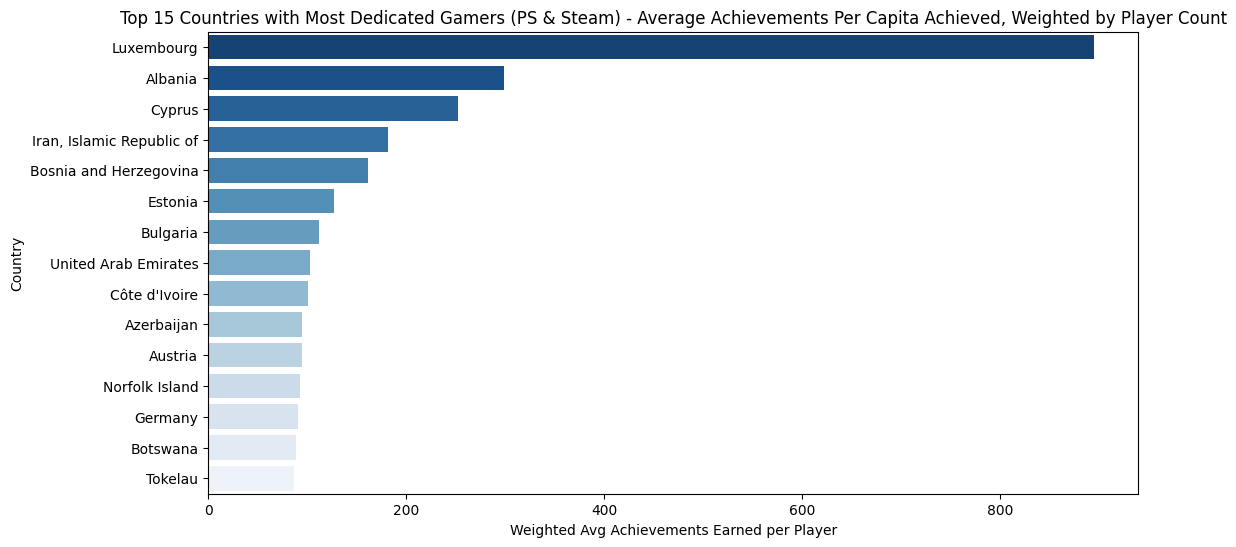

In [132]:
# weight the achievements by the number of players in that country
achievements_by_country = df_achievements.groupby('country')['achievementid'].count().reset_index()
achievements_by_country.rename(columns={'achievementid': 'total_achievements'}, inplace=True)

players_by_country = df_achievements[['playerid', 'country']].drop_duplicates().groupby('country').size().reset_index(name='num_players')

country_weighted_achievements = achievements_by_country.merge(players_by_country, on='country')

# define a smoothing factor to prevent small countries from dominating
smoothing_factor = 10

# weighted average: total achievements / (num players + smoothing factor)
country_weighted_achievements['weighted_avg_achievements'] = (
    country_weighted_achievements['total_achievements'] / 
    (country_weighted_achievements['num_players'] + smoothing_factor)
)

# sort and select top 15 countries
top_countries_weighted = country_weighted_achievements.sort_values(
    by='weighted_avg_achievements', ascending=False
).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_countries_weighted, 
    x='weighted_avg_achievements', 
    y='country', 
    palette='Blues_r'
)
plt.xlabel('Weighted Avg Achievements Earned per Player')
plt.ylabel('Country')
plt.title('Top 15 Countries with Most Dedicated Gamers (PS & Steam) - Average Achievements Per Capita Achieved, Weighted by Player Count')
plt.show()


#### Interpretation

1. **Luxembourg, Albania, and Cyprus lead the ranking**, suggesting players from these countries earn more achievements on average, even when adjusting for player count.  

2. **Smaller countries dominate the top ranks**, likely because **fewer but highly active players** skew the weighted average upwards.  

3. **Germany is the only large gaming market present**, indicating that while it has a large player base, **its most dedicated players still earn many achievements**.  

4. **Smoothing factor reduces extreme outliers**, but some smaller countries may still be overrepresented due to lower player counts.  

### 1.1 Steam and PS: For different countries, is the number of players associated with total number of achievements?

In [133]:
achievements_by_country = df_achievements.groupby('country')['achievementid'].count().reset_index()
achievements_by_country.rename(columns={'achievementid': 'total_achievements'}, inplace=True)

players_by_country = df_achievements[['playerid', 'country']].drop_duplicates().groupby('country').size().reset_index(name='num_players')

country_achievements_vs_players = achievements_by_country.merge(players_by_country, on='country')

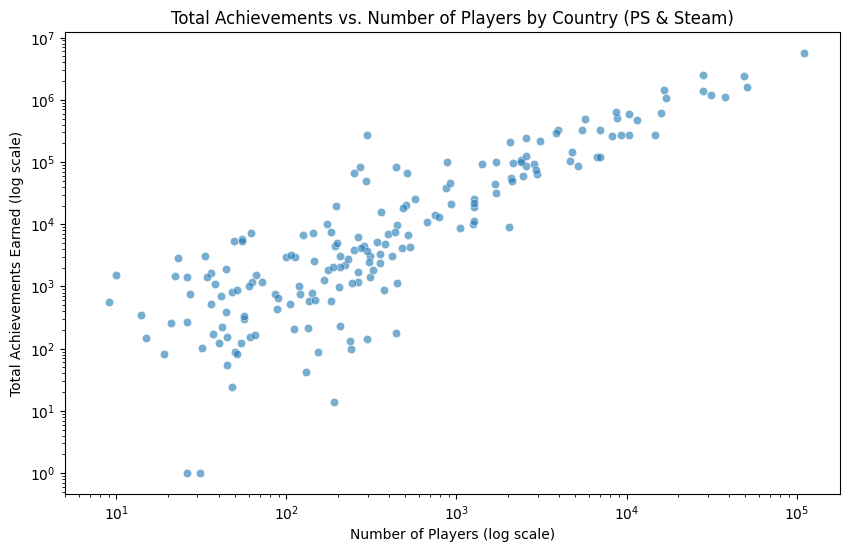

In [134]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=country_achievements_vs_players, 
    x='num_players', 
    y='total_achievements', 
    alpha=0.6
)
plt.xscale('log')  # log scale for better visualization of different-sized countries
plt.yscale('log')
plt.xlabel('Number of Players (log scale)')
plt.ylabel('Total Achievements Earned (log scale)')
plt.title('Total Achievements vs. Number of Players by Country (PS & Steam)')
plt.show()


#### Interpretation 

1. **Strong positive association**: More players in a country generally lead to more total achievements earned.  

2. Log-log scale reveals deviations: While most countries follow the trend, some have **higher or lower achievements than expected**, suggesting **differences in player engagement or gaming culture**.  

3. **Potential outliers**: Some countries with relatively few players still earn a large number of achievements, indicating **higher engagement per player** in those regions.  

### 2. How do the top 10 most **expensive** games compare in terms of player purchases and achievements?
- Another way to put: are expensive games are widely played?
- visualization type: bubble plot with price vs. number of players, sized by achievements

In [135]:
# top 10 most expensive games per platform
top_expensive_games = tidy_game_info.groupby(['platform', 'gameid']).agg(
    max_price=('price_usd', 'max')  # Ensure we take the max price for each game
).reset_index()

top_expensive_games = top_expensive_games.sort_values(['platform', 'max_price'], ascending=[True, False])
top_expensive_games = top_expensive_games.groupby('platform').head(10)

top_expensive_games

,platform,gameid,max_price
7555,ps,744199,128.3880
421,ps,12558,108.0000
425,ps,12751,108.0000
437,ps,12965,108.0000
545,ps,14749,108.0000
591,ps,15686,108.0000
2916,ps,443601,108.0000
3071,ps,452197,90.2871
3118,ps,453429,90.2871
4341,ps,520861,90.2871


In [136]:
# player purchase and achievements data for selected games
player_game_stats = merged_player_info.groupby(['player_platform', 'gameid']).agg(
    num_players=('playerid', 'nunique'),  # number of unique players who purchased the game
    total_achievements=('achievementid', 'count')  # total achievements earned in the game
).reset_index()
player_game_stats

,player_platform,gameid,num_players,total_achievements
0,ps,1.0,642,16112
1,ps,2.0,1429,38639
2,ps,3.0,201,908
3,ps,5.0,295,1614
4,ps,6.0,386,7995
...,...,...,...,...
46948,xb,755684.0,1,13
46949,xb,756274.0,3,48
46950,xb,756452.0,8,17
46951,xb,757317.0,3,3


In [137]:
top_expensive_stats = top_expensive_games.merge(
    player_game_stats.rename(columns={'player_platform': 'platform'}), 
    on=['platform', 'gameid'], how='left')

In [138]:
top_expensive_stats.duplicated().sum()

np.int64(0)

In [139]:
top_expensive_stats.dropna(inplace=True)

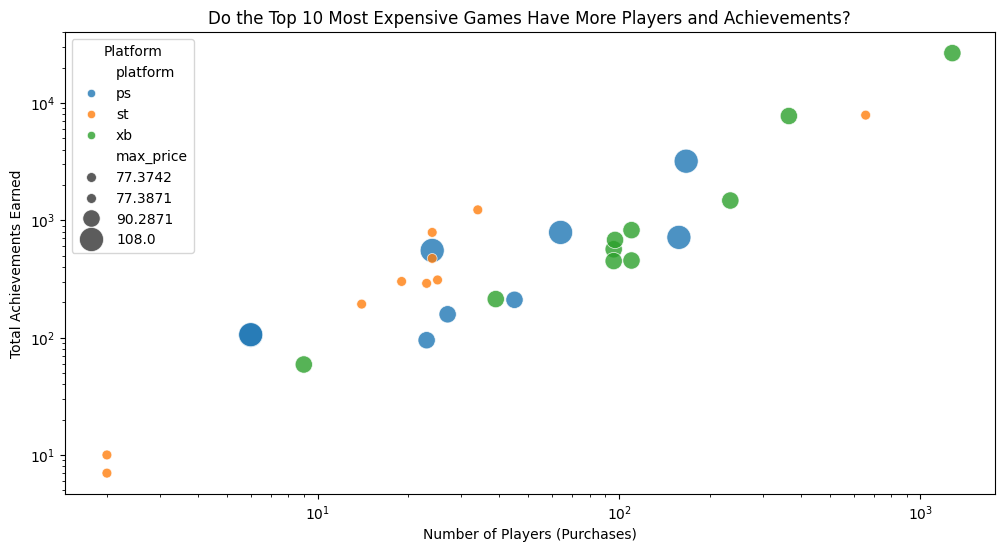

In [140]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=top_expensive_stats, 
    x='num_players', 
    y='total_achievements', 
    hue='platform', 
    size='max_price', 
    sizes=(50, 300), 
    alpha=0.8
)

plt.xlabel('Number of Players (Purchases)')
plt.ylabel('Total Achievements Earned')
plt.title('Do the Top 10 Most Expensive Games Have More Players and Achievements?')
plt.legend(title='Platform')
plt.xscale('log')  # log scale to better visualize spread
plt.yscale('log')
plt.show()

#### Interpretation

1. **Higher price ≠ more players**: Some of the most expensive games (larger bubbles) have relatively few purchases, especially on Steam (orange).  

2. Platform differences:  
   - PlayStation (blue) and Xbox (green) show higher achievement counts for expensive games with more players.  
   - Steam’s top expensive games generally have fewer players and fewer achievements.  

3. Correlation between players and achievements: Games with **more players tend to have higher total achievements**, but some outliers exist, where a game has **few players but high achievement engagement**.  

### 3. Game Ownership vs Player Dedication: How do achievement completion rates compare across platforms for the top 10 most **purchased** cross-platform games?
- visualization type: stacked bar chart for the distribution of achievement completion rates per game, grouped by platform.

In [141]:
# top 10 most purchased cross-platform games
top_purchased_games = merged_player_info.groupby(['gameid', 'player_platform']).agg(
    num_players=('playerid', 'nunique')  # unique players who own the game
).reset_index()

# cross-platform games
cross_platform_games = top_purchased_games.groupby('gameid').filter(lambda x: x['player_platform'].nunique() > 1)

top_10_purchased_games = cross_platform_games.sort_values(
    by=['player_platform', 'num_players'], ascending=[True, False]
).groupby('player_platform').head(10)  # Top 10 for each platform

top_10_purchased_games

,gameid,player_platform,num_players
25485,494230.0,ps,883
25030,487330.0,ps,818
19050,407100.0,ps,509
5472,7520.0,ps,468
6120,8850.0,ps,380
9536,18820.0,ps,348
21576,439800.0,ps,274
22314,447150.0,ps,201
4761,6120.0,ps,188
9105,17500.0,ps,143


In [142]:
# achievement completion rates for these games
achievement_completion = merged_player_info.groupby(['gameid', 'player_platform']).agg(
    total_achievements=('achievementid', 'count'),
    num_players=('playerid', 'nunique')
).reset_index()

In [143]:
achievement_completion = achievement_completion.merge(top_10_purchased_games, on=['gameid', 'player_platform', 'num_players'], how='inner')

# achievement completion rate per player 
achievement_completion['completion_rate'] = achievement_completion['total_achievements'] / achievement_completion['num_players']

In [144]:
achievement_completion

,gameid,player_platform,total_achievements,num_players,completion_rate
0,220.0,st,11265,700,16.092857
1,240.0,st,47052,950,49.528421
2,400.0,st,3965,700,5.664286
3,550.0,st,45617,2267,20.122188
4,620.0,st,24613,1438,17.116134
5,730.0,st,2915,2915,1.000000
6,1200.0,xb,19862,989,20.082912
7,1250.0,st,23033,518,44.465251
8,1520.0,xb,4459,208,21.437500
9,1530.0,xb,2745,175,15.685714


/var/folders/sd/5vy204s55_ggyjh65z1tlxg00000gn/T/ipykernel_50638/626755157.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=achievement_completion, x='player_platform', y='completion_rate', palette='muted', inner='quartile')


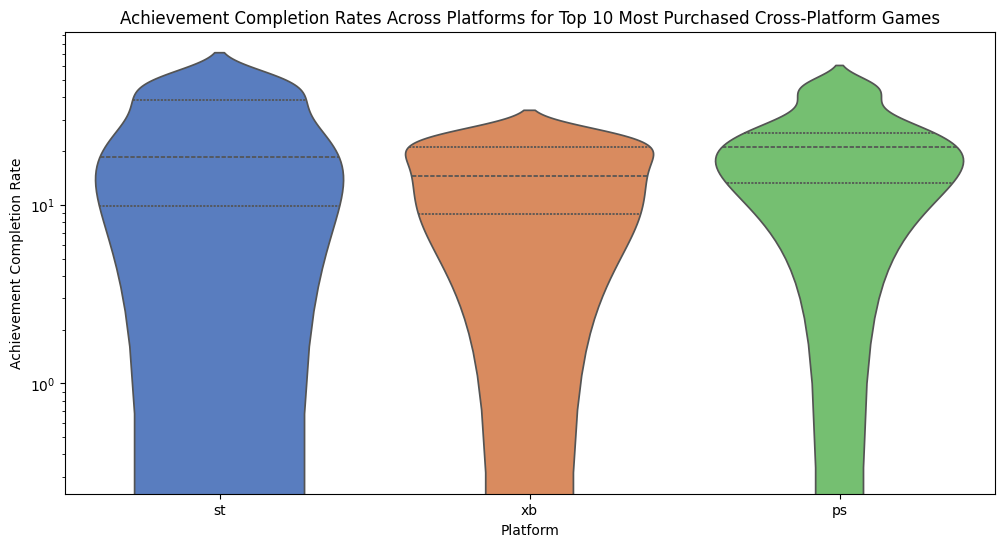

In [145]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=achievement_completion, x='player_platform', y='completion_rate', palette='muted', inner='quartile')

plt.xlabel('Platform')
plt.ylabel('Achievement Completion Rate')
plt.title('Achievement Completion Rates Across Platforms for Top 10 Most Purchased Cross-Platform Games')
plt.yscale('log')  # log scale to handle skewed distributions
plt.show()

#### Interpretation

1. Different distributions across platforms:  
   - **Steam (st) has a wider spread**, with some games having very low completion rates.  
   - **Xbox (xb) and PlayStation (ps) have more consistent distributions**, with a similar median.  

2. **Highest median on Playstation**:  
Top 10 purchased games on Playstation **tend to have slightly higher achievement completion rates** than Xbox and Steam. This suggests **players on Playstation may be more engaged in completing achievements** than players on Xbox and Steam.  

### 4. How does the number of **supported languages** vary across top 10 popular genres?
- Another way to put: Do certain genres prioritize localization more?
- visualization type: sns boxen plot for the number of supported languages grouped by genre.

In [146]:
tidy_game_info[['gameid', 'genres', 'supported_languages']].sample(5) #.duplicated().sum()

,gameid,genres,supported_languages
779428,13924,puzzle,NaN
176717,458168,Mech,"['French', 'German', 'Russian']"
284060,1265930,Adventure,"['English', 'French', 'Italian', 'German', 'Sp..."
1418318,689179,Puzzle,"['French', 'Spanish', 'German', 'Italian', 'Du..."
494238,418436,Management,"['French', 'Spanish', 'German']"


In [147]:
# each game is counted once per genre
unique_games = tidy_game_info[['gameid', 'genres', 'supported_languages']].drop_duplicates()

# the number of supported languages per game
unique_games['num_languages'] = unique_games['supported_languages'].apply(
    lambda x: len(x.strip("[]").replace("'", '').split(', ')) if isinstance(x, str) else 0
)

In [148]:
unique_games.sample(10)

,gameid,genres,supported_languages,num_languages
166329,502469,Action-RPG,"['Japanese', 'French', 'Spanish', 'German', 'I...",12
274557,1445440,Adventure,"['English', 'Japanese']",2
387864,712851,RPG,NaN,0
396754,525422,Hack & Slash,NaN,0
320751,1253,Simulation,"['French', 'Spanish', 'German', 'Italian']",4
257731,746940,Indie,"['English', 'Japanese', 'Simplified Chinese', ...",5
18807,622349,Adventure,NaN,0
165920,503746,Platformer,"['Japanese', 'French', 'Spanish', 'German', 'I...",13
371363,13059,Racing,"['Japanese', 'French', 'Spanish', 'German', 'I...",12
393270,687083,MMO,NaN,0


In [149]:
# top 10 most popular genres (by number of games)
top_genres = unique_games['genres'].value_counts().head(10).index

# filter only the top 10 most popular genres
top_genre_games = unique_games[unique_games['genres'].isin(top_genres)]

top_genre_games.sample(10)


,gameid,genres,supported_languages,num_languages
249481,871420,Indie,"['English', 'Spanish - Spain', 'Russian', 'Ger...",6
204928,759828,Platformer,NaN,0
338767,7235,Adventure,"['Japanese', 'French', 'Spanish', 'German', 'I...",10
282867,654550,Adventure,"['English', 'French', 'German', 'Spanish - Spa...",4
76421,333668,Indie,NaN,0
225334,748540,Indie,"['English', 'French', 'Italian', 'German', 'Sp...",11
275599,1649080,Casual,"['English', 'French', 'Italian', 'German', 'Sp...",11
2889,708901,Action,['Spanish'],1
256230,1711540,Simulation,"['English', 'Japanese']",2
384111,6190,Action,"['Japanese', 'French', 'Spanish', 'German', 'I...",7


/var/folders/sd/5vy204s55_ggyjh65z1tlxg00000gn/T/ipykernel_50638/1288212739.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/var/folders/sd/5vy204s55_ggyjh65z1tlxg00000gn/T/ipykernel_50638/1288212739.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Platform')


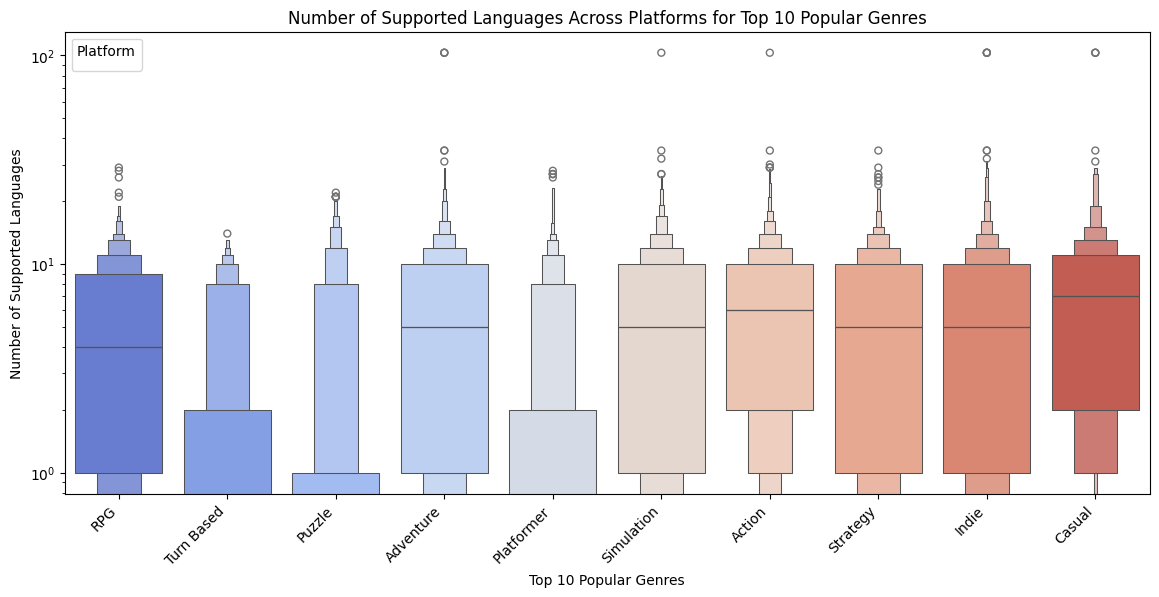

In [150]:
plt.figure(figsize=(14, 6))
sns.boxenplot(
    data=top_genre_games, 
    x='genres', 
    y='num_languages',
    palette='coolwarm'
)

plt.xlabel('Top 10 Popular Genres')
plt.ylabel('Number of Supported Languages')
plt.title('Number of Supported Languages Across Platforms for Top 10 Popular Genres')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')  # log scale for better distribution visibility
plt.legend(title='Platform')

#### Interpretation 
1. **Casual and Action games tend to have higher median localization support**, suggesting these genres prioritize broader accessibility.  

2. **Puzzle, Turn-Based, and Platformer games tend to have fewer supported languages**, indicating less focus on localization, possibly due to minimal text/dialogue.  

3. **Large variability across genres**: While most genres show a broad distribution, some outliers support significantly more languages.

## Comparative Analysis
>Compare and contrast different subsets of your data. This can include comparisons over time, across different categories, or any other relevant segmentation.  Note that for some projects, the nature of this comparative analysis will be obvious.  For others, you will need to think about how you might subset your data.

In this section, we conduct a comparative analysis to explore how various aspects of gaming behavior and trends differ across platforms. By segmenting the data based on gaming platforms, we aim to uncover key differences in game ownership patterns, game popularity, release trends, and genre evolution. The primary subsets used in this analysis include:

- Platform-Based Subsets: The core comparison is across different gaming platforms, allowing us to examine how user behavior varies between them.
- Genre-Based Subsets: We analyze how different genres perform across platforms, focusing on ownership, prise, and released years.
- Temporal Subsets: For analyses related to game release periods and genre trends, we incorporate a time-based perspective to understand historical shifts in gaming preferences.

### 1. **Platform-Based Differences in Game Ownership**
- **Chosen Subset**: Players who own games on different platforms.
- **Analysis**: Compare the number of games owned across platforms.

We first count the number of games each player owns by counting the number of unique `gameid` in the `library` column of the purchased_games dataframe. 

In [151]:
import warnings
warnings.filterwarnings("ignore")
steam_library = steam_purchased_games['library'].apply(lambda x: x.count(',') + 1 if isinstance(x, str) and x != '[]' else 0)
ps_library = ps_purchased_games['library'].apply(lambda x: x.count(',') + 1 if isinstance(x, str) and x != '[]' else 0)
xbox_library = xbox_purchased_games['library'].apply(lambda x: x.count(',') + 1 if isinstance(x, str) and x != '[]' else 0)
# Combine the library sizes into a single DataFrame for better visualization
library_sizes = pd.DataFrame({
    'Platform': ['Steam'] * len(steam_library) + ['PlayStation'] * len(ps_library) + ['Xbox'] * len(xbox_library),
    'Library Size': pd.concat([steam_library, ps_library, xbox_library])
})

In [152]:
# summarize the library sizes
library_summary = library_sizes.groupby('Platform')['Library Size'].describe()
library_summary = library_summary.rename(columns={
    'count': 'Count', 
    'mean': 'Mean', 
    'std': 'Std Dev', 
    'min': 'Min', 
    '25%': '25th Percentile', 
    '50%': 'Median', 
    '75%': '75th Percentile', 
    'max': 'Max'
})
library_summary = library_summary.reset_index()
library_summary = library_summary.round(2)
print(library_summary)

      Platform     Count    Mean  Std Dev  Min  25th Percentile  Median  \
0  PlayStation   46582.0  233.86   322.17  1.0             81.0   157.0   
1        Steam  102548.0  109.79   600.47  0.0              0.0     0.0   
2         Xbox   46466.0  272.63   376.01  1.0             85.0   172.0   

   75th Percentile      Max  
0            283.0  13540.0  
1             65.0  32463.0  
2            323.0   9018.0  


Then we create a boxplot to visualize the distribution of game ownership across platforms.

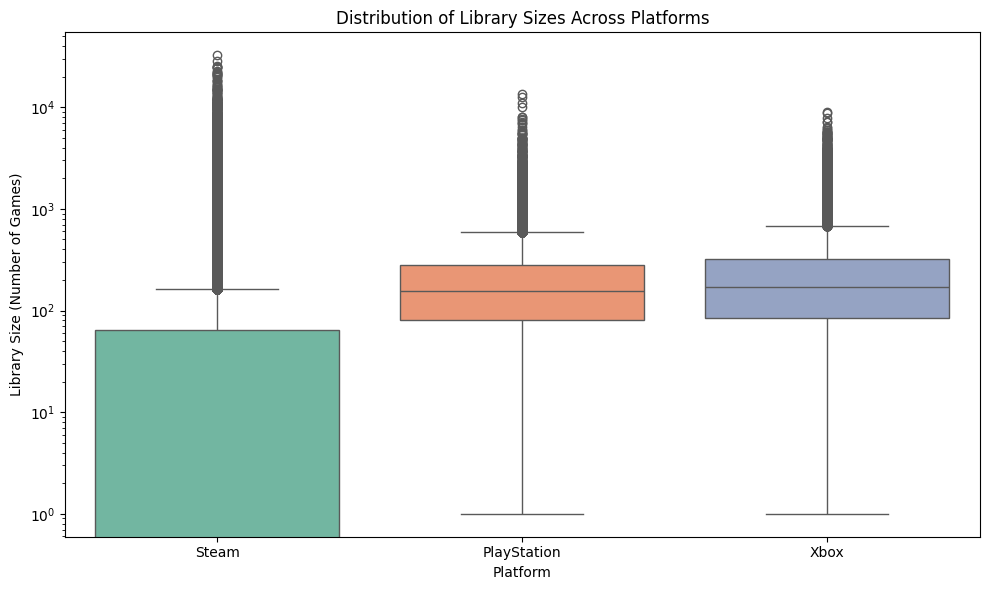

In [153]:
# Create a boxplot to visualize the distribution of library sizes across platforms
plt.figure(figsize=(10, 6))
sns.boxplot(x='Platform', y='Library Size', data=library_sizes, palette='Set2')
plt.title('Distribution of Library Sizes Across Platforms')
plt.xlabel('Platform')
plt.ylabel('Library Size (Number of Games)')
plt.yscale('log')  # log scale for better visualization
plt.tight_layout()
plt.show()

#### **Key Observations**
- **Steam** players tend to own more games on average compared to PlayStation and Xbox players.
- The distribution of game ownership is right-skewed for all platforms, indicating that a small number of players own a large number of games.

### 2. Comparations of Game Popularity Across Platforms
- **Chosen Subset**: Game popularity based on the number of players who purchased each game.
- **Analysis**: Compare the number of players for the top 500 most popular games across platforms.


In this analysis, we aim to determine the most owned games among players by extracting game IDs from their Steam libraries and merging this data with an existing dataset of Steam games.

In [154]:
from collections import Counter
import re

all_games = steam_purchased_games['library'].dropna().astype(str).apply(lambda x: re.findall(r'\d+', x))
game_counts = Counter([game for sublist in all_games for game in sublist])
steam_game_counts = pd.DataFrame(game_counts.items(), columns=['game_id', 'count'])

# Ensure both columns have the same data type before merging
steam_game_counts['game_id'] = steam_game_counts['game_id'].astype(int)
steam_games['gameid'] = steam_games['gameid'].astype(int)

# merge with steam_games to get game info
steam_game_counts = steam_game_counts.merge(steam_games, left_on='game_id', right_on='gameid', how='inner').drop(columns=['gameid'])
# sort by count
steam_game_counts = steam_game_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
steam_game_counts.head(10)

,game_id,count,title,developers,publishers,genres,supported_languages,release_date
0,730,43967,Counter-Strike 2,['Valve'],['Valve'],"['Action', 'Free To Play']","['Czech', 'Danish', 'Dutch', 'English', 'Finni...",2012-08-21
1,578080,28356,PUBG: BATTLEGROUNDS,['PUBG Corporation'],"['KRAFTON, Inc.']","['Action', 'Adventure', 'Massively Multiplayer...","['English', 'Korean', 'Simplified Chinese', 'F...",2017-12-21
2,550,24727,Left 4 Dead 2,['Valve'],['Valve'],['Action'],"['Danish', 'Dutch', 'English', 'Finnish', 'Fre...",2009-11-16
3,218620,23785,PAYDAY 2,['OVERKILL - a Starbreeze Studio.'],['Starbreeze Publishing AB'],"['Action', 'RPG']","['English', 'German', 'French', 'Italian', 'Sp...",2013-08-13
4,304930,21620,Unturned,['Smartly Dressed Games'],['Smartly Dressed Games'],"['Action', 'Adventure', 'Casual', 'Indie', 'Fr...",['English'],2017-07-07
5,1172470,21197,Apex Legends™,['Respawn'],['Electronic Arts'],"['Action', 'Adventure', 'Free To Play']","['English', 'French', 'Italian', 'German', 'Sp...",2020-11-04
6,230410,18906,Warframe,['Digital Extremes'],['Digital Extremes'],"['Action', 'RPG', 'Free To Play']","['English', 'German', 'French', 'Italian', 'Ko...",2013-03-25
7,271590,17904,Grand Theft Auto V,['Rockstar North'],['Rockstar Games'],"['Action', 'Adventure']","['English', 'French', 'Italian', 'German', 'Sp...",2015-04-13
8,407530,17711,ARK: The Survival Of The Fittest,"['Studio Wildcard', 'Instinct Games', 'Efecto ...",['Studio Wildcard'],"['Action', 'Adventure', 'Indie', 'Massively Mu...","['English', 'Simplified Chinese', 'Traditional...",2017-08-29
9,4000,17676,Garry's Mod,['Facepunch Studios'],['Valve'],"['Casual', 'Indie', 'Simulation']","['English', 'French', 'Italian', 'German', 'Sp...",2006-11-29


In [155]:
all_games = ps_purchased_games['library'].dropna().astype(str).apply(lambda x: re.findall(r'\d+', x))
game_counts = Counter([game for sublist in all_games for game in sublist])
ps_game_counts = pd.DataFrame(game_counts.items(), columns=['game_id', 'count'])
# Ensure both columns have the same data type before merging
ps_game_counts['game_id'] = ps_game_counts['game_id'].astype(int)
ps_games['gameid'] = ps_games['gameid'].astype(int)
# merge with ps_games to get game info
ps_game_counts = ps_game_counts.merge(ps_games, left_on='game_id', right_on='gameid', how='inner').drop(columns=['gameid'])
# sort by count
ps_game_counts = ps_game_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
ps_game_counts.head(10)

,game_id,count,title,platform,developers,publishers,genres,supported_languages,release_date
0,7779,30721,Grand Theft Auto V,PS4,['rockstar north'],['Rockstar Games'],['Action'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2022-03-15
1,16508,26571,Horizon Zero Dawn,PS4,['Guerrilla Games'],['Sony Interactive Entertainment'],"['Open World', 'Action-RPG', 'Role Playing']","['Japanese', 'French', 'Spanish', 'German', 'I...",2017-02-28
2,333860,26142,Call of Duty Modern Warfare,PS4,['Infinity Ward'],['Activision'],"['Battle Royale', 'First Person Shooter']","['Japanese', 'French', 'Spanish', 'German', 'I...",2019-10-25
3,167482,25707,Red Dead Redemption 2,PS4,['Rockstar Games'],['Rockstar Games'],['Adventure'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2018-10-26
4,6988,25620,The Last of Us Remastered,PS4,['Naughty Dog'],['Sony Computer Entertainment America'],"['Action', 'Adventure']","['Japanese', 'French', 'Spanish', 'German', 'I...",2014-07-29
5,163258,25183,Marvel's Spider-Man,PS4,['Insomniac Games'],['Sony Interactive Entertainment'],"['Open World', 'Stealth', ""Beat 'em up""]","['Japanese', 'French', 'Spanish', 'German', 'I...",2018-09-07
6,10403,24754,Call of Duty: Black Ops III,PS4,['Treyarch'],['Activision'],"['shooter', 'FPS']","['Japanese', 'French', 'Spanish', 'German', 'I...",2015-11-06
7,176538,23019,Apex Legends,PS4,['Respawn Entertainment'],['Electronic Arts'],"['Free to Play', 'shooter']","['Japanese', 'French', 'Spanish', 'German', 'I...",2022-03-29
8,5446,22320,The Playroom,PS4,['sony online entertainment'],['sony online entertainment'],"['Free to Play', 'Tutorial']","['Japanese', 'French', 'Spanish', 'German', 'I...",2013-11-29
9,6185,21447,inFAMOUS Second Son,PS4,['Sucker Punch'],['Sony Computer Entertainment America'],"['Action', 'Adventure']","['Japanese', 'French', 'Spanish', 'German', 'I...",2014-03-21


In [156]:
all_games = xbox_purchased_games['library'].dropna().astype(str).apply(lambda x: re.findall(r'\d+', x))
game_counts = Counter([game for sublist in all_games for game in sublist])
xb_game_counts = pd.DataFrame(game_counts.items(), columns=['game_id', 'count'])
# Ensure both columns have the same data type before merging
xb_game_counts['game_id'] = xb_game_counts['game_id'].astype(int)
xbox_games['gameid'] = xbox_games['gameid'].astype(int)
# merge with xbox_games to get game info
xb_game_counts = xb_game_counts.merge(xbox_games, left_on='game_id', right_on='gameid', how='inner').drop(columns=['gameid'])
# sort by count
xb_game_counts = xb_game_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
xb_game_counts.head(10)


,game_id,count,title,developers,publishers,genres,supported_languages,release_date
0,1226,26852,Call of Duty Black Ops,['Treyarch'],['Activision'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2011-05-03
1,1141,26806,Halo 3,['Bungie'],['Microsoft Studios'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2007-09-25
2,1142,26768,Grand Theft Auto IV,['rockstar north'],['Rockstar Games'],"['Action', 'Adventure']","['Japanese', 'French', 'Spanish', 'German', 'I...",2009-10-13
3,1225,26077,Call of Duty: Modern Warfare 2 (2009),['Infinity Ward'],['Activision'],"['Action', 'Adventure', 'shooter']","['Japanese', 'French', 'Spanish', 'German', 'I...",2011-02-15
4,7756,24996,Grand Theft Auto V,['rockstar north'],['Rockstar Games'],"['Action', 'Adventure']","['Japanese', 'French', 'Spanish', 'German', 'I...",2022-03-15
5,18204,24899,Fortnite,['Epic Games'],['Epic Games'],"['Third Person Shooter', 'Battle Royale', 'Tow...","['Japanese', 'French', 'Spanish', 'German', 'I...",2017-07-25
6,1216,24868,Halo: Reach,['Bungie'],['Microsoft Game Studios'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2010-09-14
7,1155,24797,Gears of War,['Epic Games Inc.'],['Microsoft Studios'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2009-12-29
8,1220,24748,Gears of War 2,['Epic Games Inc.'],['Microsoft Game Studios'],['shooter'],"['French', 'Spanish', 'German', 'Italian', 'Ru...",2008-11-07
9,1043,24683,Hexic HD,['Carbonated Games'],['Microsoft Studios'],['puzzle'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2005-11-22


#### **Key Observations**
- The most popular game on **Steam** is **Counter-Strike Global Offensive**, with a staggering 1,000,000+ players.
- On **PlayStation**, the most popular game is **Call of Duty: Modern Warfare**, with over 500,000 players.
- The most popular game on **Xbox** is **Fortnite**, with over 300,000 players.
- The popularity of games varies significantly across platforms, with rare games overlapping between platforms.

### 3. The Evolution of Popular Games: Comparing Release Peaks Across Gaming Platforms
- **Chosen Subset**: Release year distribution for the top 500 games of different platforms.
- **Analysis**: We analyze the release year distribution for the top 500 games across platforms to understand how game popularity has evolved over time.


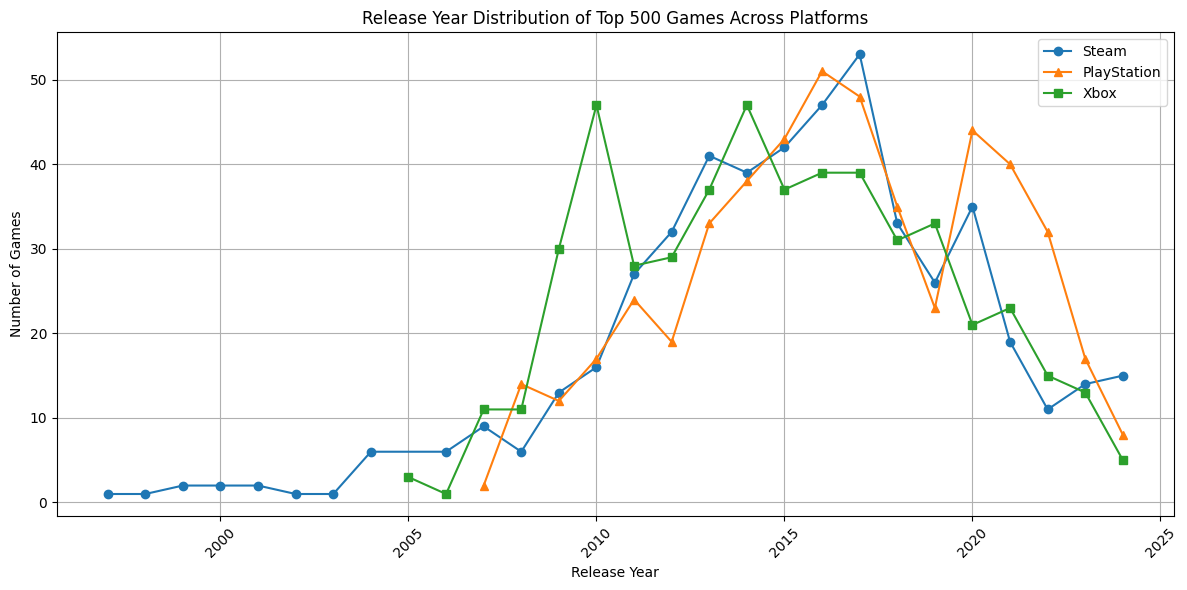

In [157]:
top_500_steam_games = steam_game_counts.head(500)
top_500_ps_games = ps_game_counts.head(500)
top_500_xb_games = xb_game_counts.head(500)

top_500_steam_games['release_year'] = pd.to_datetime(top_500_steam_games['release_date']).dt.year
top_500_ps_games['release_year'] = pd.to_datetime(top_500_ps_games['release_date']).dt.year
top_500_xb_games['release_year'] = pd.to_datetime(top_500_xb_games['release_date']).dt.year

steam_release_years = top_500_steam_games['release_year'].value_counts().sort_index()
ps_release_years = top_500_ps_games['release_year'].value_counts().sort_index()
xb_release_years = top_500_xb_games['release_year'].value_counts().sort_index()
# Display the release year distributions for the top 500 games on each platform
plt.figure(figsize=(12, 6))
plt.plot(steam_release_years.index, steam_release_years.values, label='Steam', marker='o')
plt.plot(ps_release_years.index, ps_release_years.values, label='PlayStation', marker='^')
plt.plot(xb_release_years.index, xb_release_years.values, label='Xbox', marker='s')
plt.title('Release Year Distribution of Top 500 Games Across Platforms')
plt.xlabel('Release Year')
plt.ylabel('Number of Games')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Key Observations**
- The **golden age** for game on all platforms appears to be around 2015, with a significant spike in the number of the most popular games released.
- For **Steam**, it contans more classical games released before 2005, which are still popular today, indicating a longer lifespan for these games.
- For **Xbox**, it shows a rapid increase in 2010, aheading the other two platforms, while dying down earlier than the others.


### 4. Shifting Trends in Game Genres: A Cross-Platform Temporal Comparison
- **Chosen Subset**: Genre distribution for the top 500 games of different platforms.
- **Analysis**: We analyze the genre distribution for the top 500 games across platforms to understand how game genres have evolved over time.

#### 4.1 **Top Game Genres Across Platforms**
This analysis aims to identify and compare the **most common genres** among the **top 500 games** for **Steam, PlayStation, and Xbox**. 

In [158]:
def extract_genres_and_years(df):
    genres_list = df['genres'].dropna().apply(lambda x: [g.strip() for g in x.strip("[]").replace("'", "").split(', ')])
    years_list = df['release_year']
    return genres_list.tolist(), years_list.tolist()

steam_genres, steam_years = extract_genres_and_years(top_500_steam_games)
ps_genres, ps_years = extract_genres_and_years(top_500_ps_games)
xb_genres, xb_years = extract_genres_and_years(top_500_xb_games)

In [159]:
# Flatten the list of lists
flattened_steam_genres = [genre for sublist in steam_genres for genre in sublist]
flattened_ps_genres = [genre for sublist in ps_genres for genre in sublist]
flattened_xb_genres = [genre for sublist in xb_genres for genre in sublist]

steam_genre_counts = Counter(flattened_steam_genres)
ps_genre_counts = Counter(flattened_ps_genres)
xb_genre_counts = Counter(flattened_xb_genres)

steam_genre_df = pd.DataFrame.from_dict(steam_genre_counts, orient='index', columns=['count']).reset_index().rename(columns={'index': 'genre'})
ps_genre_df = pd.DataFrame.from_dict(ps_genre_counts, orient='index', columns=['count']).reset_index().rename(columns={'index': 'genre'})
xb_genre_df = pd.DataFrame.from_dict(xb_genre_counts, orient='index', columns=['count']).reset_index().rename(columns={'index': 'genre'})
# Merge the genre dataframes for all platforms
merged_genre_df = steam_genre_df.merge(ps_genre_df, on='genre', how='outer', suffixes=('_steam', '_ps'))
merged_genre_df = merged_genre_df.merge(xb_genre_df, on='genre', how='outer', suffixes=('', '_xb'))
merged_genre_df.fillna(0, inplace=True)
merged_genre_df.columns = ['genre', 'count_steam', 'count_ps', 'count_xb']
# Normalize the counts to get percentages
total_counts = merged_genre_df[['count_steam', 'count_ps', 'count_xb']].sum()
merged_genre_df['percentage_steam'] = (merged_genre_df['count_steam'] / total_counts['count_steam']) * 100
merged_genre_df['percentage_ps'] = (merged_genre_df['count_ps'] / total_counts['count_ps']) * 100
merged_genre_df['percentage_xb'] = (merged_genre_df['count_xb'] / total_counts['count_xb']) * 100
# Sort the genres by total count across all platforms
merged_genre_df['total_count'] = merged_genre_df[['count_steam', 'count_ps', 'count_xb']].sum(axis=1)
merged_genre_df.sort_values(by='total_count', ascending=False, inplace=True)
# Plot the genre distribution for the top 500 games across platforms
print(merged_genre_df.head(10))

                    genre  count_steam  count_ps  count_xb  percentage_steam  \
2                  Action        360.0      67.0     206.0         27.863777   
6               Adventure        196.0      76.0     201.0         15.170279   
36                  Indie        175.0      11.0      14.0         13.544892   
82                shooter          0.0      52.0     100.0          0.000000   
51                    RPG        112.0      29.0       6.0          8.668731   
58             Simulation         80.0       8.0      28.0          6.191950   
30           Free To Play        103.0       0.0       0.0          7.972136   
63               Strategy         92.0       0.0       1.0          7.120743   
46             Open World          0.0      48.0      26.0          0.000000   
39  Massively Multiplayer         58.0       9.0       0.0          4.489164   

    percentage_ps  percentage_xb  total_count  
2        8.556833      20.355731        633.0  
6        9.706258      

In [160]:
# list the top 10 genres of each platform
top_steam_genres = merged_genre_df.nlargest(15, 'count_steam')
top_ps_genres = merged_genre_df.nlargest(15, 'count_ps')
top_xb_genres = merged_genre_df.nlargest(15, 'count_xb')
print("Top 15 Steam Genres:\n", top_steam_genres[['genre', 'count_steam']])
print("Top 15 PlayStation Genres:\n", top_ps_genres[['genre', 'count_ps']])
print("Top 15 Xbox Genres:\n", top_xb_genres[['genre', 'count_xb']])

Top 15 Steam Genres:
                     genre  count_steam
2                  Action        360.0
6               Adventure        196.0
36                  Indie        175.0
51                    RPG        112.0
30           Free To Play        103.0
63               Strategy         92.0
58             Simulation         80.0
15                 Casual         65.0
39  Massively Multiplayer         58.0
61                 Sports         16.0
52                 Racing         14.0
21           Early Access         12.0
19  Design & Illustration          2.0
10       Audio Production          1.0
8    Animation & Modeling          1.0
Top 15 PlayStation Genres:
                        genre  count_ps
6                  Adventure      76.0
2                     Action      67.0
82                   shooter      52.0
46                Open World      48.0
67      Third Person Shooter      37.0
31              Free to Play      37.0
55              Role Playing      32.0
62            

Then we create a bar plot to visualize the distribution of game genres across platforms.

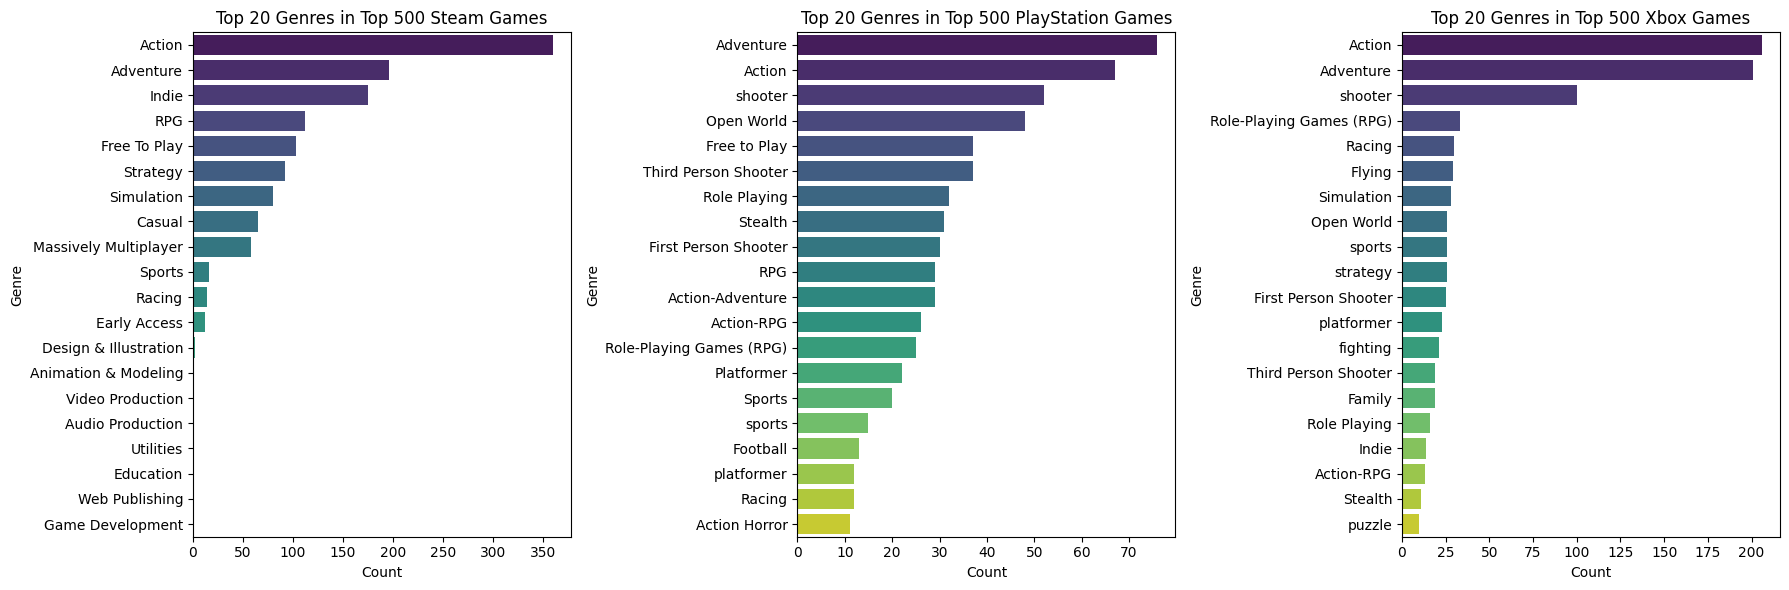

In [161]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='count', y='genre', data=steam_genre_df.sort_values(by='count', ascending=False).head(20), palette='viridis')
plt.title('Top 20 Genres in Top 500 Steam Games')
plt.xlabel('Count')
plt.ylabel('Genre')

plt.subplot(1, 3, 2)
sns.barplot(x='count', y='genre', data=ps_genre_df.sort_values(by='count', ascending=False).head(20), palette='viridis')
plt.title('Top 20 Genres in Top 500 PlayStation Games')
plt.xlabel('Count')
plt.ylabel('Genre')

plt.subplot(1, 3, 3)
sns.barplot(x='count', y='genre', data=xb_genre_df.sort_values(by='count', ascending=False).head(20), palette='viridis')
plt.title('Top 20 Genres in Top 500 Xbox Games')
plt.xlabel('Count')
plt.ylabel('Genre')

plt.tight_layout()
plt.show()

##### **Key Observations**
- The most common genre across all platforms is **Action**, followed by **Adventure** and **RPG**.
- **Steam** has a more diverse range of genres, with a significant number of **Indie** and **Simulation** games.
- **PlayStation** and **Xbox** have a higher concentration of **Action** and **Adventure** games, indicating a preference for these genres among their player bases.

#### 4.2 **Game Genre Trends Over Time**
In this analysis, we aim to determine how game genres have evolved over time across platforms.

In [162]:
def count_genres_by_year(genres, years):
    genre_year_counts = {}
    for genre_list, year in zip(genres, years):
        for genre in genre_list:
            if genre not in genre_year_counts:
                genre_year_counts[genre] = Counter()
            genre_year_counts[genre][year] += 1
    return genre_year_counts

steam_genre_year_counts = count_genres_by_year(steam_genres, steam_years)
ps_genre_year_counts = count_genres_by_year(ps_genres, ps_years)
xb_genre_year_counts = count_genres_by_year(xb_genres, xb_years)

def get_top_genres(genre_year_counts, top_n=5):
    total_counts = {genre: sum(year_counts.values()) for genre, year_counts in genre_year_counts.items()}
    top_genres = sorted(total_counts, key=total_counts.get, reverse=True)[:top_n]
    return top_genres

Top 5 Steam Genres: ['Action', 'Adventure', 'Indie', 'RPG', 'Free To Play']


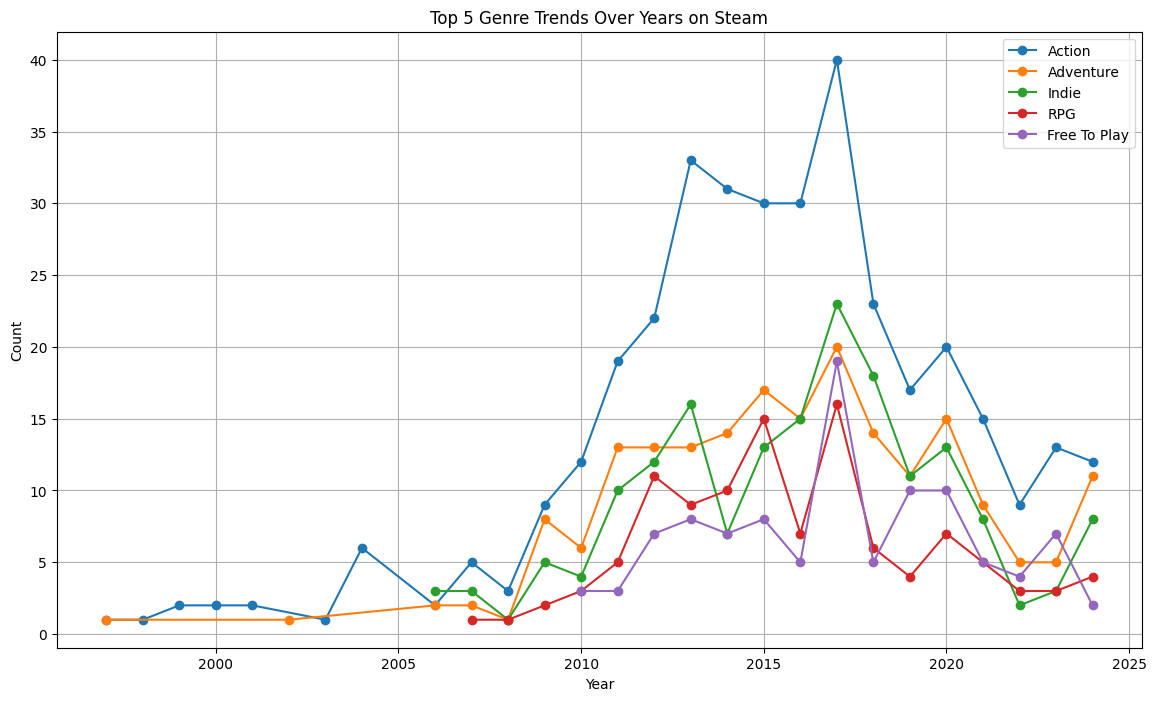

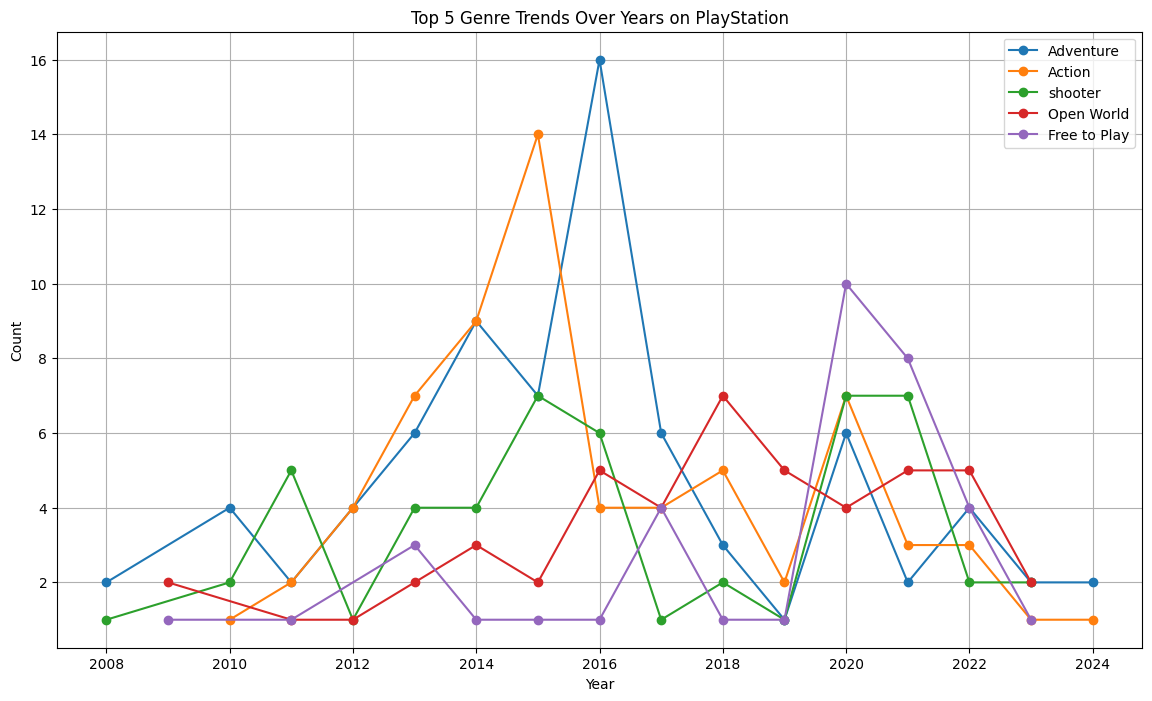

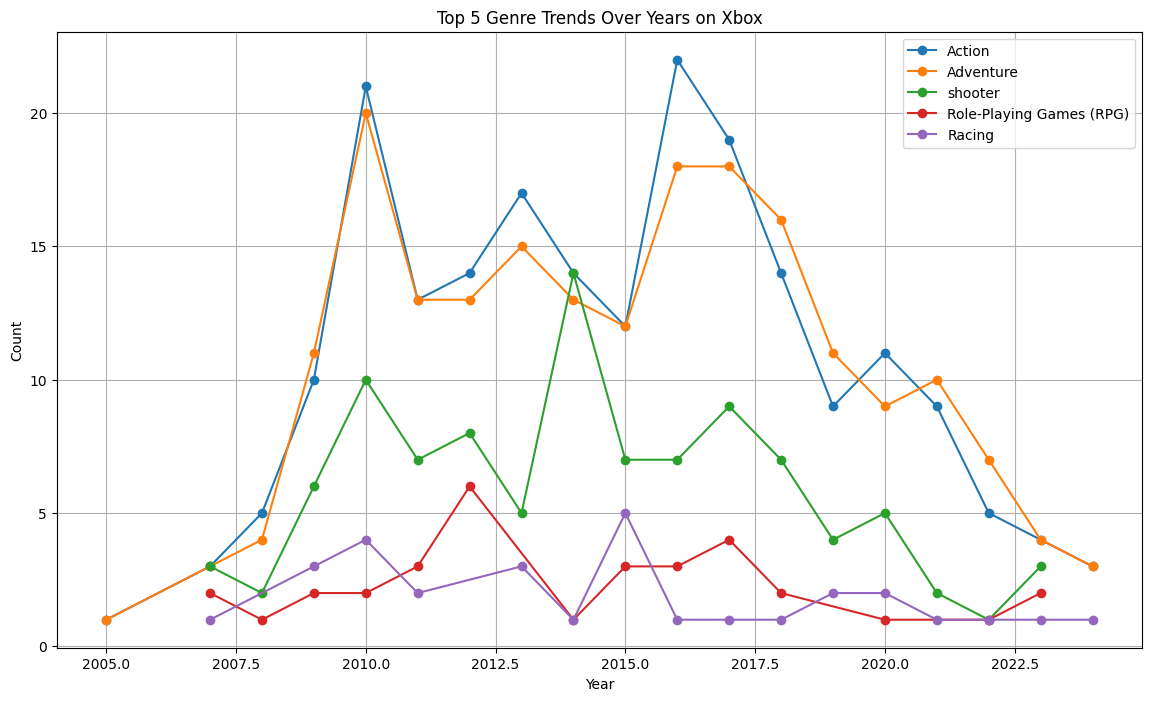

In [163]:
top_5_steam_genres = get_top_genres(steam_genre_year_counts)
top_5_ps_genres = get_top_genres(ps_genre_year_counts)
top_5_xb_genres = get_top_genres(xb_genre_year_counts)
print(f"Top 5 Steam Genres: {top_5_steam_genres}")
def plot_genre_trends(genre_year_counts, top_genres, platform_name):
    """
    Plots the trends of the top genres over years for a specific platform.

    Args:
    genre_year_counts (dict): Dictionary where keys are genres and values are year-wise counts.
    top_genres (list): List of top genres to plot.
    platform_name (str): The name of the platform.
    """
    plt.figure(figsize=(14, 8))
    
    for genre in top_genres:
        years = sorted(genre_year_counts[genre].keys())
        counts = [genre_year_counts[genre][year] for year in years]
        plt.plot(years, counts, marker='o', label=genre)
    
    plt.title(f'Top 5 Genre Trends Over Years on {platform_name}')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot trends for each platform
plot_genre_trends(steam_genre_year_counts, top_5_steam_genres, 'Steam')
plot_genre_trends(ps_genre_year_counts, top_5_ps_genres, 'PlayStation')
plot_genre_trends(xb_genre_year_counts, top_5_xb_genres, 'Xbox')

##### **Key Observations**
- The **Action** genre has consistently remained popular across all platforms, domaining the game genre landscape over years.
- The **open-world** genre has seen a significant rise on **PlayStation** around 2015-2018, which may attribute to the success of games like **zelda: breath of the wild** and **red dead redemption 2**.
- The **Free-to-play** genre see a rapid increase on **Playstation** in 2020, which may be due to the rise of free games.

## Multivariate Analysis
> Perform multivariate analysis to understand the relationships among three or more variables in your dataset. Use techniques like cross-tabulation, pivot tables, and multivariate graphs.


### 1. Cross-Tabulation: Game developers across platforms

In [164]:
game_info = merged_game_info.copy()
game_info['developers'] = game_info['developers'].dropna().apply(lambda x: x.strip("[]").replace("'", "").split(', '))
game_info['genres'] = game_info['genres'].dropna().apply(lambda x: x.strip("[]").replace("'", "").split(', '))
game_info_exploded = game_info.explode('developers')

# Create a cross-tabulation of genres by platform
developer_platform_ct = pd.crosstab(game_info_exploded['developers'], game_info_exploded['platform'])
developer_platform_ct = developer_platform_ct.loc[(developer_platform_ct != 0).any(axis=1)]
developer_platform_ct = developer_platform_ct[developer_platform_ct.sum(axis=1) > 10]  # filter out low counts
developer_platform_ct = developer_platform_ct.sort_values(by=list(developer_platform_ct.columns), ascending=False)
print('Developer-Platform Cross Tabulation:')
print(developer_platform_ct.head(20))

Developer-Platform Cross Tabulation:
platform                        ps   st    xb
developers                                   
eastasiasoft                  7353    0  2029
ChiliDog Interactive          2341   50    50
EXE-CREATE                    2099   20  1069
Ratalaika Games               1246    0   192
Atlus                         1096    0   335
Pigeon Dev Games              1010    0   230
Alawar Entertainment           967    0   227
WayForward Technologies        961    0   273
Panda Indie Studio             909  157   174
Lillymo Games                  851  233   220
HugePixel                      849  153   182
Konami Digital Entertainment   813   49   522
Capcom Entertainment           757    0   712
Nukearts Studio                752  370   370
lightUP                        737  235   165
DuCats Games Studio            719  144   194
Kaneda Games                   700  150   150
Milestone S.r.l.               688  682   532
Tonguc Bodur                   687    0   1

#### **Key Observations**
- The **cross-tabulation** of game developers across platforms reveals that certain developers are more prevalent on specific platforms.
- For example, **ChiliDog Interactive** is primarily associated with **PlayStation**.

### 2. Pivot Table: Average Game Price by Genre and Platform

Average Price by Genre and Platform(USD):
platform           ps         st         xb
genres                                     
Action      14.240554  19.642034  19.141640
Adventure   17.586675  19.590437  20.812882
Casual      17.769204  12.807887  19.073333
Gore        29.990000   5.517778  29.990000
Indie       12.201990  14.809120  14.412194
RPG         22.899843  22.255956  22.847953
Racing      12.690000  21.499112  14.742086
Simulation  21.750932  20.960341  21.912924
Sports      26.017805  23.773565  33.922105
Strategy    24.371517  20.827776  27.668838


<Figure size 1200x600 with 0 Axes>

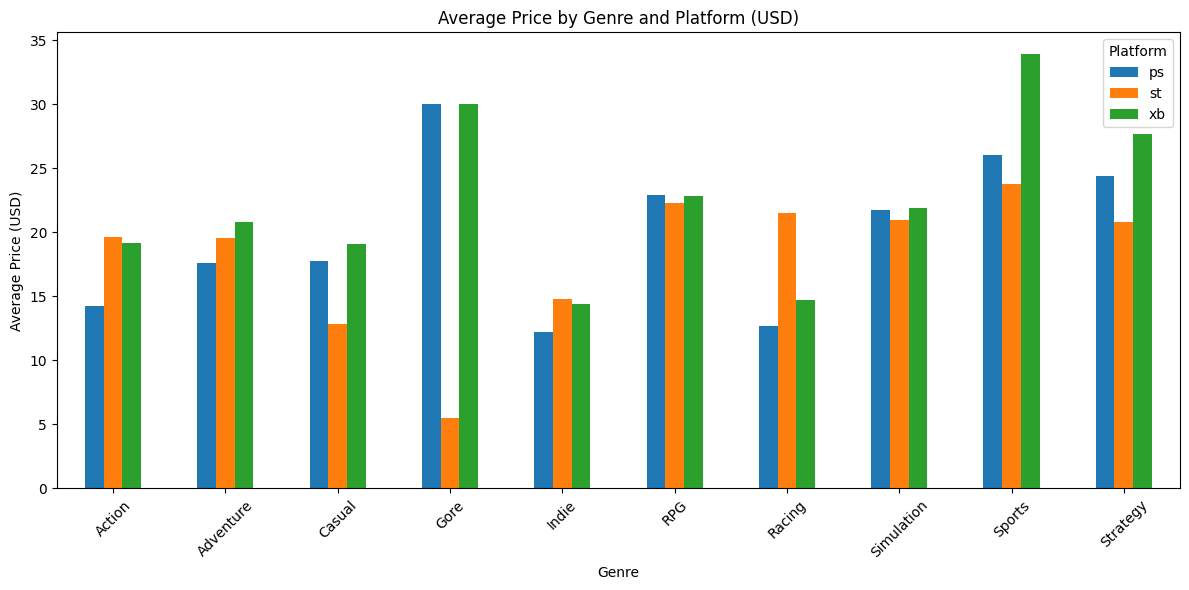

In [165]:

game_info_exploded = game_info.explode('genres')
price_pivot = game_info_exploded.pivot_table(index='genres', columns='platform', values='usd', aggfunc='mean').dropna()
print('Average Price by Genre and Platform(USD):')
print(price_pivot.head(10))
# Plot the average price by genre and platform
plt.figure(figsize=(12, 6))
price_pivot.head(10).plot(kind='bar', figsize=(12, 6))
plt.title('Average Price by Genre and Platform (USD)')
plt.xlabel('Genre')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

#### **Key Observations**
- The **pivot table** and the bar plot show that certain genres tend to be more expensive on specific platforms.
- For instance, **RPG** games are generally more expensive on **PlayStation** compared to **Steam** and **Xbox**.

### 3. Multivariate Graph: Game Popularity by Genre, Price, and Release Year

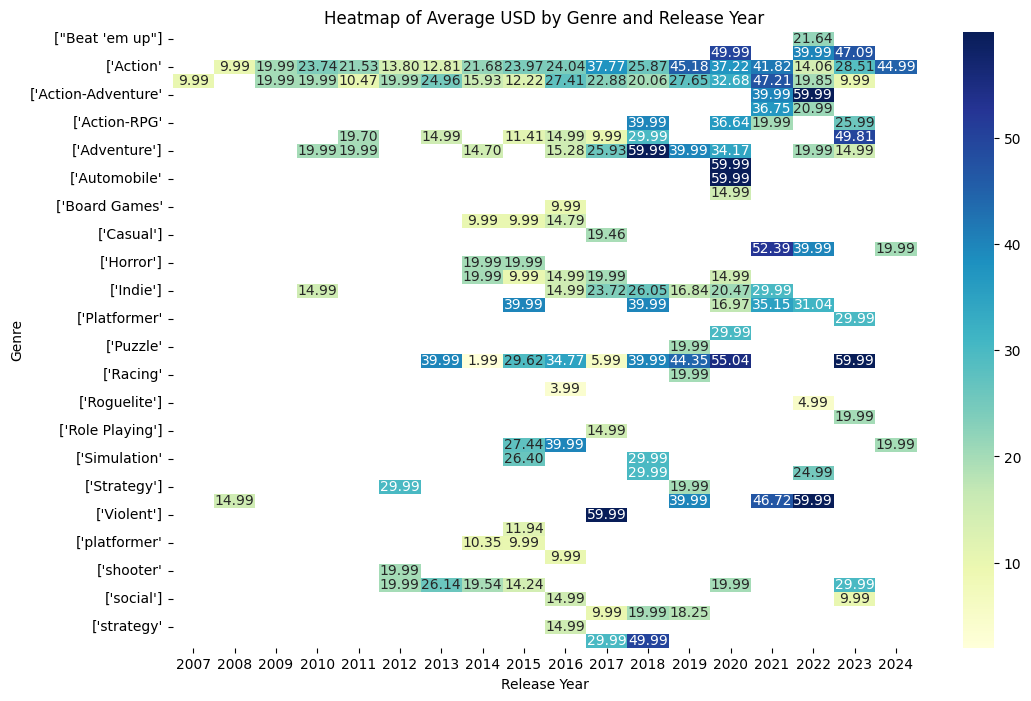

In [166]:
# Combine top 500 games data from all platforms
top_500_games = pd.concat([top_500_ps_games, top_500_steam_games, top_500_xb_games])

# Explode genres to have one genre per row
top_500_games_exploded = top_500_games.explode('genres')
top_500_games_usd = game_info[game_info['gameid'].isin(top_500_games_exploded['game_id'])][['gameid', 'usd']]

top_500_games_exploded['num_supported_languages'] = top_500_games_exploded['supported_languages'].apply(lambda x: x.count(';') + 1 if isinstance(x, str) and x != '' else 0)


top_500_games_exploded['genres'] = top_500_games_exploded['genres'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)
top_500_games_data = top_500_games_exploded.merge(top_500_games_usd, left_on='game_id', right_on='gameid', how='left')
top_500_games_data = top_500_games_data[['title', 'count', 'release_year', 'num_supported_languages', 'genres', 'usd']]

heatmap_data = top_500_games_data.pivot_table(index='genres', columns='release_year', values='usd', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap of Average USD by Genre and Release Year')
plt.xlabel('Release Year')
plt.ylabel('Genre')
plt.show()

#### **Key Observations**
- Games with more popular genres tend to have higher prices, such as **Action**,**Adventure**, and **Automobile**.
- Games released in the last few years (2018-2022) tend to be more expensive.

## Synthesis
> Synthesize the findings from your descriptive and inferential statistics along with your graphical analyses to answer your research questions. Discuss how the combination of the datasets has provided added value in terms of insights or capabilities that would not be possible with the individual datasets in isolation.

### Overarching Research Questions 

1.	How **game attributes** (e.g., prices, genres, achievements, supported_languages) influence **engagement** (e.g., number of players) and **accessibility** (e.g., pricing, supported_languages)

    - **Game complexity V.S. price**: Are games with more achievements associated with higher prices? 

    - **Player reach V.S. language accessibility**: Do games with more supported languages attract more players?  

    - **Cross-platform availability V.S. pricing**: Do expensive vs. cheap games have different likelihoods of being cross-platform?

    - **Genre V.S. localization**: How does the number of supported languages vary across top 10 popular genres?

2.	How **player behavior** (e.g., number and speed of acheivements unlocked) varies by **country** and **platform**

    - **Regional differences in gaming dedication**: Which countries have the most dedicated gamers (Steam & PS)?

    - **Achievement speed by country**: Do players from different countries tend to complete achievements faster (Steam & PS)?

    - **Country-level correlation between players & achievements**: For different countries, is the number of players associated with the total number of achievements?

3.	How **high-value and popular games** perform (e.g., number of achievements unlocked)

    - **Top 10 most expensive games V.S. player investment**: How do the top 10 most expensive games compare in terms of player purchases and achievements

    - **Top 10 most purchased shared games across platforms**: How do achievement completion rates compare across platforms for the top 10 most purchased cross-platform games?

    
### Added Value of the Combination of Datasets
The combined dataset enriches our analysis by providing a holistic view with games, players, and platforms as the key stakeholders in evaluating game popularity. By combining player and game data, we gain valuable insights into player behavior, offering a more comprehensive perspective on game performance. This integration allows us to go beyond analyzing individual platform distributions and enables us to explore relationships between game attributes and player engagement across multiple platforms. 

## Reflection
> Include a section (using one or more markdown blocks) at the end of your notebook in which you reflect on the process of analyzing the data. Discuss any challenges you encountered and how you overcame them. Critically evaluate the limitations of your analysis and suggest areas for further research or improvement.

### Challenges
- The data consists mostly of categorical features. To address this, we used group-by operations and counted the unique values within each group for analysis and visualization.

- Given the large dataset size, especially after merging, we employed sampling and focused on the top entries for analysis and visualization.

- Some hypothesis tests were limited by data types or sample size, resulting in weaker correlations. We adjusted our approach accordingly.

- To reveal clearer patterns or associations, we applied normalization or log transformations to adjust the units and scale of the data.

### Limitations
- Our questions might appear somewhat scattered, possibly due to our analysis process being more methodology-driven than question-driven. However, these questions do offer a broad range of perspectives.

- We flattened our merged data to simplify manipulation for each section, but this led to some repetitive steps across different sections, such as frequently grouping by certain features and assigning to new variables, and exploding list elements into new rows for counting.

- Due to a limited number of our data features, there may be other lurking variables at play, which could explain why we did not observe very strong correlations in our hypothesis testing.

# SI 618 WN Project Part III

> 1. Import the dataset you have chosen based on your earlier assignments.

In [167]:
steam_game_counts.to_csv("steam_game_counts.csv", index=False)
ps_game_counts.to_csv("ps_game_counts.csv", index=False)
xb_game_counts.to_csv("xb_game_counts.csv", index=False)
merged_game_info.to_csv("merged_game_info.csv", index=False)

merged_game_info = pd.read_csv("merged_game_info.csv") #(Original dataframe located in "Part I - Game Info Across Platforms")
steam_game_counts = pd.read_csv("steam_game_counts.csv")#(Original dataframe located in "Part II - Comparative Analysis")
ps_game_counts = pd.read_csv("ps_game_counts.csv")
xb_game_counts = pd.read_csv("xb_game_counts.csv")

> 2. Clean your dataset, handling missing values, inconsistencies, and any other issues you encounter.  You should be able to reuse code from earlier work to help you do this, although you may need to make some modifications.

In [168]:
# detecting platforms from game titles and forming platform list for each game

steam_titles = set(steam_game_counts["title"].str.lower().str.strip())
ps_titles = set(ps_game_counts["title"].str.lower().str.strip())
xb_titles = set(xb_game_counts["title"].str.lower().str.strip())

unique_games = merged_game_info[["title"]].drop_duplicates().copy()
unique_games["title_norm"] = unique_games["title"].str.lower().str.strip()

def detect_platforms(title_norm):
    platforms = []
    if title_norm in steam_titles:
        platforms.append("steam")
    if title_norm in ps_titles:
        platforms.append("ps")
    if title_norm in xb_titles:
        platforms.append("xbox")
    return ",".join(platforms)

unique_games["platform_deduced"] = unique_games["title_norm"].apply(detect_platforms)

game_info_platform = merged_game_info.merge(
    unique_games[["title", "platform_deduced"]],
    on="title",
    how="left"
)


In [169]:
game_info_platform['platform_deduced'].value_counts()

platform_deduced
steam,ps,xbox    358754
ps,xbox           68228
steam,xbox         1844
xbox               1704
steam               473
steam,ps            458
                    441
ps                   83
Name: count, dtype: int64

In [170]:
# counting achievements per game
achievement_counts = game_info_platform.groupby("gameid").size().reset_index(name="achievement_count")
game_info_unique = game_info_platform.drop_duplicates(subset=["gameid"])
game_info_unique = game_info_unique.merge(achievement_counts, on="gameid", how="left")
game_info_unique.rename(columns={"gameid": "game_id"}, inplace=True)

In [171]:

# Merge the game counts with the game info
st_count = game_info_unique[game_info_unique["platform"] == 'st'].merge(steam_game_counts[["game_id", "count"]].rename(columns={"count": "count"}),how="left", on="game_id")
ps_count = game_info_unique[game_info_unique["platform"] == 'ps'].merge(ps_game_counts[["game_id", "count"]].rename(columns={"count": "count"}),how="left", on="game_id")
xb_count = game_info_unique[game_info_unique["platform"] == 'xb'].merge(xb_game_counts[["game_id", "count"]].rename(columns={"count": "count"}),how="left", on="game_id")
game_count = pd.concat([st_count, ps_count, xb_count], ignore_index=True)

game_count.head(5)

,game_id,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,usd,eur,gbp,jpy,rub,platform,platform_deduced,achievement_count,count
0,1432050,Nobody Saves the World,['DrinkBox Studios'],['DrinkBox Studios'],"['Action', 'Adventure', 'Indie', 'RPG']","['English', 'French', 'Italian', 'German', 'Ko...",2022-01-18,1432050_EAwards_1,Castle Crasher,Complete the Legendary Dungeon: Grand Castle,8.74,8.57,6.82,899.0,308.0,st,"steam,ps,xbox",41,681.0
1,1430680,Clash: Artifacts of Chaos,['ACE Team'],['Nacon'],"['Action', 'Adventure', 'Indie']","['English', 'French', 'Italian', 'German', 'Sp...",2023-03-09,1430680_Achievement15,Target Practice,Hit all targets with rocks while training at t...,29.99,29.99,24.99,3400.0,1100.0,st,"steam,ps,xbox",21,98.0
2,1426900,Dread Nautical,['Zen Studios'],['Zen Studios'],"['Indie', 'RPG']","['English', 'French', 'Italian', 'German', 'Sp...",2020-10-27,1426900_NEW_ACHIEVEMENT_1_0,What the Hell,Reach the foghorn on the first deck,19.99,16.79,15.49,2050.0,NaN,st,"steam,ps,xbox",25,19.0
3,1424770,Aery - Little Bird Adventure,['EpiXR Games UG'],['EpiXR Games UG'],"['Adventure', 'Casual', 'Indie', 'Simulation']",['English'],2020-10-16,1424770_1,I,Finish Act 1,3.49,2.84,2.59,360.0,87.0,st,"ps,xbox",8,NaN
4,1424860,Bish Bash Bots,['CATASTROPHIC_OVERLOAD'],['Firestoke'],"['Action', 'Casual', 'Strategy']","['English', 'French', 'German', 'Spanish - Spa...",2023-10-19,1424860_CompleteSuburbia,Desperate housebots,NaN,19.99,19.99,14.99,2900.0,999.0,st,"steam,ps,xbox",40,40.0


In [172]:
# normalize the count by platform(min-max scaling)
game_count["normalized_count"] = game_count.groupby("platform")["count"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [173]:
# remove empty platform_deduced values
game_count=game_count[game_count["platform_deduced"].str.strip() != ""]
game_count['platform_deduced'].value_counts()

platform_deduced
steam,ps,xbox    11253
ps,xbox           3385
steam,xbox          74
xbox                71
steam               16
steam,ps            13
ps                   7
Name: count, dtype: int64

In [174]:
# calculate years since release
game_count["release_date"] = pd.to_datetime(game_count["release_date"], errors="coerce")
game_count["years_since_release"] = 2025 - game_count["release_date"].dt.year
game_count.drop(columns=["release_date"], inplace=True)

In [175]:
# calculate the number of supported languages
game_count["num_supported_languages"] = game_count["supported_languages"].apply(
    lambda x: len(eval(x)) if pd.notnull(x) else 0
)
game_count.drop(columns=["supported_languages"], inplace=True)

In [176]:
# only keep needed columns
game_count=game_count[['game_id', 'title', 'platform_deduced', 'count','achievement_count','genres','usd', 'normalized_count', 'years_since_release', 'num_supported_languages']]

In [177]:
# one-hot encode the platform_deduced column
game_count["platform_list"] = game_count["platform_deduced"].str.split(",")

one_hot = (
    game_count[["title", "platform_list"]]
    .explode("platform_list")
    .dropna()
    .assign(flag=1)
    .pivot_table(index="title", columns="platform_list", values="flag", fill_value=0)
    .reset_index()
)

game_count = game_count.merge(one_hot, on="title", how="left")
game_count.drop(columns=["platform_list"], inplace=True)

In [178]:
# one-hot encode the genres column
genre_aliases = {
    "action": ["action"],
    "adventure": ["adventure"],
    "rpg": ["rpg", "role playing", "role-playing games (rpg)"],
    "shooter": ["shooter", "first person shooter", "third person shooter", "fps", "tps"],
    "sports": ["sports"],
    "racing": ["racing"],
    "indie": ["indie"],
    "open_world": ["open world"]
}

for col, keywords in genre_aliases.items():
    game_count[f"is_{col}"] = game_count["genres"].apply(
        lambda x: int(any(keyword in str(x).lower() for keyword in keywords))
    )
game_count.head()

,game_id,title,platform_deduced,count,achievement_count,genres,usd,normalized_count,years_since_release,num_supported_languages,...,steam,xbox,is_action,is_adventure,is_rpg,is_shooter,is_sports,is_racing,is_indie,is_open_world
0,1432050,Nobody Saves the World,"steam,ps,xbox",681.0,41,"['Action', 'Adventure', 'Indie', 'RPG']",8.74,0.028591,3,10,...,1.0,1.0,1,1,1,0,0,0,1,0
1,1430680,Clash: Artifacts of Chaos,"steam,ps,xbox",98.0,21,"['Action', 'Adventure', 'Indie']",29.99,0.004078,2,13,...,1.0,1.0,1,1,0,0,0,0,1,0
2,1426900,Dread Nautical,"steam,ps,xbox",19.0,25,"['Indie', 'RPG']",19.99,0.000757,5,14,...,1.0,1.0,0,0,1,0,0,0,1,0
3,1424770,Aery - Little Bird Adventure,"ps,xbox",NaN,8,"['Adventure', 'Casual', 'Indie', 'Simulation']",3.49,NaN,5,1,...,0.0,1.0,0,1,0,0,0,0,1,0
4,1424860,Bish Bash Bots,"steam,ps,xbox",40.0,40,"['Action', 'Casual', 'Strategy']",19.99,0.001640,2,8,...,1.0,1.0,1,0,0,0,0,0,0,0


In [179]:
# fix usd price and drop coloumns with missing values
game_count['usd'].fillna(0, inplace=True)
game_count_cleaned = game_count.dropna()
len(game_count_cleaned)

13726

In [180]:
game_count_cleaned.drop(columns=['game_id', 'platform_deduced', 'genres', 'count'], inplace=True)
game_count_cleaned.rename(columns={'normalized_count': 'possession_count', 'usd': 'price_usd'}, inplace=True)
game_count_cleaned.head()

,title,achievement_count,price_usd,possession_count,years_since_release,num_supported_languages,ps,steam,xbox,is_action,is_adventure,is_rpg,is_shooter,is_sports,is_racing,is_indie,is_open_world
0,Nobody Saves the World,41,8.74,0.028591,3,10,1.0,1.0,1.0,1,1,1,0,0,0,1,0
1,Clash: Artifacts of Chaos,21,29.99,0.004078,2,13,1.0,1.0,1.0,1,1,0,0,0,0,1,0
2,Dread Nautical,25,19.99,0.000757,5,14,1.0,1.0,1.0,0,0,1,0,0,0,1,0
4,Bish Bash Bots,40,19.99,0.001640,2,8,1.0,1.0,1.0,1,0,0,0,0,0,0,0
5,The Solitaire Conspiracy,20,11.99,0.004036,5,8,1.0,1.0,1.0,0,0,0,0,0,0,1,0


### Justification

> Justify the preprocessing choices made, ensuring that they align with the analytical techniques you plan to use later.

#### Preprocessing Justification

1. Platform deduction and normalization  
   - Titles were matched across Steam, PlayStation, and Xbox using normalized lowercase strings. This helped identify cross-platform releases.  
   - **One-hot encoding** was applied to platform presence to represent each game’s distribution across systems.  
   - This supports cluster separation later on by capturing whether a game is exclusive or widely available.

2. Achievement and popularity metrics  
   - The number of achievements per game serves as a rough proxy for engagement or game depth.  
   - Platform-specific counts (e.g., number of players or owners) were normalized using **min-max scaling** per platform to make them comparable.  
   - Normalized possession data is especially useful for techniques like PCA and clustering, which are sensitive to scale.

3. Temporal feature extraction  
   - Instead of using raw release dates, the number of years since release was calculated.  
   - This simplifies temporal trends and allows downstream analysis to capture differences between newer and older games.

4. Language support quantification  
   - The number of supported languages was extracted as a numerical feature.  
   - This gives insight into accessibility and global reach, which could differentiate games in clustering or prediction tasks.

5. Genre encoding with simplification  
   - Rather than one-hot encoding all genre tags, **common genres were grouped using aliases** (e.g., merging FPS and TPS under 'shooter').  
   - Binary flags like `is_rpg` or `is_open_world` were used to represent these categories.  
   - This avoids high-dimensional sparse vectors and keeps the input space compact and interpretable.

6. Final cleanup and renaming  
   - Columns like `game_id`, `genres`, and `count` were dropped due to redundancy or non-numeric content.  
   - Normalized `count` was renamed to `possession_count`, and `usd` to `price_usd`, to improve clarity.  
   - These steps ensure the final dataset is clean, all-numeric, and ready for dimensionality reduction, clustering, or classification tasks.

#### Alignment with Analytical Techniques

- Dimensionality Reduction (e.g., PCA, UMAP)
  - All features are numeric or binary, which avoids the need for additional encoding or transformations during projection.
  - Min-max normalization on platform-specific count ensures comparable feature scales for distance-preserving techniques like PCA.
  - Genre aliasing reduces sparsity while preserving semantic meaning, which is useful for projecting genre patterns without fragmenting into too many axes.
  - Dropping high-cardinality categorical fields (like raw genres or platform_deduced) avoids noise and overfitting in lower dimensions.
  - Simplified time feature (years since release) replaces raw datetime and offers linear interpretability in reduced dimensions.

- Clustering (e.g., Agglomerative clustering, K-Means)
  - Normalized possession counts and scaled numeric features ensure that distance metrics are not dominated by any single variable.
  - One-hot encoded platforms and genre flags provide clear binary separation across product types and user expectations.
  - Features like achievement_count and num_supported_languages help capture variation in engagement depth and accessibility.
  - Removing missing data and redundant columns reduces dimensional noise and minimizes the risk of skewed clusters due to null handling.
  - The resulting feature set enables meaningful groupings such as "niche indie RPGs" or "multi-platform mainstream shooters."

- Classification (e.g. Random Forest, XGBoost)
  - All fields are model-ready numeric or one-hot encoded, eliminating the need for additional preprocessing in supervised learning.
  - Variables like price_usd, years_since_release, and possession_count offer clear predictive signals for popularity, genre, or platform classification tasks.
  - One-hot encoded genre and platform columns can optionally serve as clean, interpretable multi-label classification targets.
  - The balance of continuous and categorical indicators supports generalization across models ranging from linear classifiers to ensemble methods.
  - Flattened tabular format ensures compatibility with standard ML pipelines while maintaining traceability back to game metadata.

## Clustering Analysis

> Clearly define your analytical goal and the rationale behind choosing either clustering or classification.

Our analytical goal is to understand how video games across platforms differ in terms of popularity, accessibility, and genre characteristics, and to group or predict games based on these underlying patterns. Specifically, we aim to uncover whether distinct clusters of games naturally emerge based on shared traits, and whether these clusters or individual features can help us classify games into predefined categories such as genre or platform exclusivity.

We chose clustering because it allows us to explore the structure of the dataset without needing labeled outputs. It helps us identify natural groupings of games based on features like platform availability, possession count, supported languages, release timing, and genre. Clustering is especially useful here since our dataset spans multiple platforms and genres, and we expect hidden patterns—such as high-engagement indie games or legacy titles with niche appeal—to emerge organically.

We initially decide to cluster for game recommendation, but our dataset does not naturally form clusters, so we use  UMAP + KMeans to force practical segments.

In [181]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import umap

In [182]:
df = game_count_cleaned.copy()
df.shape

(13726, 17)

In [183]:
X = df.drop(columns=["title"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.24131841, -0.54469878,  0.15249188, ..., -0.18516286,
         1.91912567, -0.11331122],
       [-0.18185088,  1.16582432, -0.27360371, ..., -0.18516286,
         1.91912567, -0.11331122],
       [-0.09721703,  0.36087227, -0.33134222, ..., -0.18516286,
         1.91912567, -0.11331122],
       ...,
       [-0.20300935, -0.04160375, -0.3368478 , ..., -0.18516286,
        -0.52107062, -0.11331122],
       [-0.0549001 ,  1.97077637, -0.32154775, ..., -0.18516286,
        -0.52107062, -0.11331122],
       [-0.3511186 , -0.44407978, -0.3368478 , ..., -0.18516286,
        -0.52107062, -0.11331122]])

### Low Hopkins score

In [184]:
from pyclustertend import hopkins
score = hopkins(X_scaled, X_scaled.shape[0])
print(f"Hopkins score: {score}")

Hopkins score: 0.009703544265901304


In [185]:
# Fit PCA on the scaled data
pca = PCA().fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to reach 80%
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components to reach 80% variance: {n_components_80}")

Number of components to reach 80% variance: 11


Needing 11 out of 16 components to reach 80% variance suggests the PCA dimension reduction is not necessarily useful for our dataset.

In [186]:
### KMeans after PCA

# Reduce dimensions to 11
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)

# Find the optimal number of clusters using silhouette scores
silhouette_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

optimal_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on silhouette score (PCA space): {optimal_k}")

# Final KMeans clustering using optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
final_labels = kmeans_final.fit_predict(X_pca)
df["Cluster_KMeansPCA"] = final_labels

# Evaluate
sil_final = silhouette_score(X_pca, final_labels)
print("Silhouette Score (Final KMeans after PCA):", sil_final)

For n_clusters = 2, the silhouette score is 0.754
For n_clusters = 3, the silhouette score is 0.215
For n_clusters = 4, the silhouette score is 0.210
For n_clusters = 5, the silhouette score is 0.212
For n_clusters = 6, the silhouette score is 0.211
For n_clusters = 7, the silhouette score is 0.214
For n_clusters = 8, the silhouette score is 0.246
For n_clusters = 9, the silhouette score is 0.277
For n_clusters = 10, the silhouette score is 0.294

Optimal number of clusters based on silhouette score (PCA space): 2
Silhouette Score (Final KMeans after PCA): 0.7542206741245153


Two clusters may oversimplify the market. Our goal is to understand distinct game types or genres for market segmentation, so we decide to explore different clustering techniques.

In [211]:
### Agglomerative after PCA

for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    print(f"k = {k}, silhouette score = {sil:.3f}")

k = 2, silhouette score = 0.170
k = 3, silhouette score = 0.215
k = 4, silhouette score = 0.152
k = 5, silhouette score = 0.179
k = 6, silhouette score = 0.181
k = 7, silhouette score = 0.220
k = 8, silhouette score = 0.245
k = 9, silhouette score = 0.274
k = 10, silhouette score = 0.275


Low silouette scores suggest our data likely doesn’t form clear clusters directly in high-dimensional space.

###  UMAP + KMeans

In [188]:
# UMAP projection
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Silhouette Score (KMeans after UMAP): 0.42167023


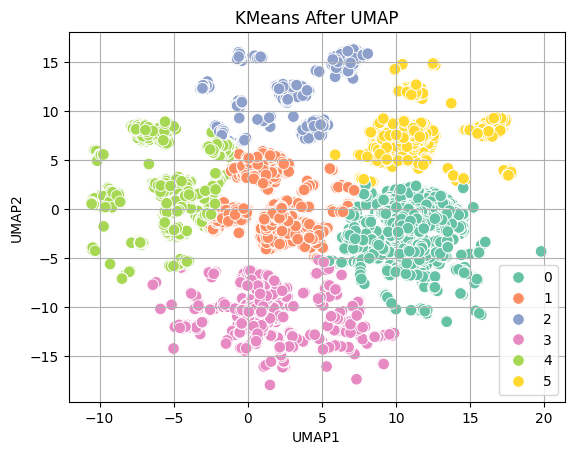

In [189]:
# KMeans clustering in UMAP space
kmeans_umap = KMeans(n_clusters=6, random_state=42).fit(X_umap)
df["Cluster_KMeansUMAP"] = kmeans_umap.labels_

sil_kmeans_umap = silhouette_score(X_umap, kmeans_umap.labels_)
print("Silhouette Score (KMeans after UMAP):", sil_kmeans_umap)

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=kmeans_umap.labels_, palette="Set2", s=70)
plt.title("KMeans After UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.show()

In [190]:
df["Cluster_KMeansUMAP"] = kmeans_umap.labels_
cluster_summary = df.groupby("Cluster_KMeansUMAP").mean(numeric_only=True)
cluster_summary

,achievement_count,price_usd,possession_count,years_since_release,num_supported_languages,ps,steam,xbox,is_action,is_adventure,is_rpg,is_shooter,is_sports,is_racing,is_indie,is_open_world,Cluster_KMeansPCA
Cluster_KMeansUMAP,,,,,,,,,,,,,,,,,
0,33.248002,17.385448,0.013850,4.144125,4.140574,1.00000,0.944658,0.999112,0.033442,0.028411,0.036401,0.002368,0.000592,0.000296,0.015389,0.000000,0.00000
1,30.050884,16.876348,0.018862,4.702458,4.113842,1.00000,0.995688,0.999569,0.181113,0.455369,0.284174,0.000000,0.000000,0.000000,0.000862,0.000000,0.00000
2,31.721535,17.556558,0.021883,5.154196,6.270007,0.95771,0.947300,0.994144,0.592062,0.321405,0.127521,0.000000,0.325960,0.003904,0.506181,0.082628,0.04229
3,19.831863,7.105676,0.002851,2.596842,0.633070,1.00000,0.047376,0.999536,0.074779,0.081282,0.001393,0.019508,0.000000,0.000000,0.001393,0.000000,0.00000
4,35.547452,21.029899,0.046931,5.074692,5.938049,1.00000,0.937170,0.998682,0.619947,0.433656,0.195518,0.183656,0.044376,0.196837,0.093585,0.000000,0.00000
5,25.132881,12.036038,0.016923,5.679437,4.887973,1.00000,0.904947,1.000000,0.005820,0.218235,0.049952,0.028613,0.000000,0.000000,0.913191,0.022793,0.00000


### Interpretation and Analysis of Clusters (KMeans after UMAP)

> Interpret and analyze the resulting clusters and discuss insights you've gained from them.

#### Overall clustering performance
- The silhouette score after applying KMeans on UMAP-transformed data is 0.4089, substantially higher than KMeans after PCA or Agglomerative clustering.
- This suggests UMAP captured non-linear structure more effectively, and the clusters in the visualization appear compact and well-separated.

#### Key Insights by Cluster

1. **Cluster 0** - The mainstream cross-platform hits
    - High price (`$18.97`), high achievements (`33.4`), decent language support  
    - Almost universally available (Steam, PS, Xbox all >99%)  
    - Very low genre diversity (almost no action/adventure/rpg/etc.), suggesting utility or non-genre-specific titles  
    - This cluster includes widely accessible games across all platforms, priced at a premium, with many achievements. The genre neutrality suggests these might be general-purpose, casual, or utility-driven games (e.g., party games, compilations, or broad-appeal titles). Their central position in UMAP also reflects their balanced nature.

2. **Cluster 1** – Indie-focused, moderately priced games  
    - Moderately priced (`$12.46`) but strong presence on all platforms (ps: 0.979; steam: 0.992; xbox: 0.996)
    - High `is_indie` flag (88%)  
    - Moderate achievements and language support  
    - Games here are mostly indie, cross-platform, and priced slightly lower. The high is_indie signal (88%) defines the cluster. These could be successful games from indie studios that scaled across platforms, such as Hades, Celeste, or Hollow Knight. The far-right position in UMAP shows they are structurally distinct. 

3. **Cluster 2** – Big genre-driven games with rich content  
    - Mixed genre presence: moderate action (37%), RPG (21%), sports (22%)  
    - Above-average achievement count and pricing
    - Likely a mix of genre-specific, narrative-driven, and replayable games  
    - High language support suggests wide international reach  
    - Still highly multi-platform (ps: 0.991; steam: 0.881; xbox: 0.999)
    - This cluster contains big genre-driven games with rich content (evident from achievements and high ownership). Its mix of RPG, sports, and action points to titles like FIFA, Assassin’s Creed, or Mass Effect. Slightly more Steam-leaning. These are strong all-around performers.

4. **Cluster 3** – Console-first action/adventure games 
    - These games almost always appear on both Xbox and PlayStation, but only about a third are on Steam, suggesting they’re either console-first titles or have delayed/staggered PC releases.
    - With is_action = 38% and is_adventure = 37%, these games tend to focus heavily on narrative and immersive gameplay.
    - Low is_indie and is_rpg scores suggest they are studio-developed, mid-tier or flagship releases, rather than open-world or indie RPGs.
    - The pricing (~$12.78) and achievements (~25.2) are moderate, implying these games are not AAA blockbusters but rather consistent and well-performing console experiences.
    - The relatively low language support (2.73) suggests limited localization, possibly regional releases or mid-budget titles.
    - Cluster 3 reflects console-first action/adventure games that are highly represented on both Xbox and PlayStation, but underrepresented on Steam. These games tend to focus on immersive narratives, come from established studios, and are moderately priced with moderate engagement. Their mid-range achievements and lower localization hint at focused regional releases or mid-tier development budgets.

5. **Cluster 4** – Budget, niche, or legacy titles  
    - Lowest price (`$7.80`), lowest ownership percentage, lowest year_since_release (2.512683), and weakest language support 
    - Lowest steam availability (ps: 1.000000; steam: 0.321291; xbox: 1.000000)
    - Cluster 4 contains low-cost, recently released console games with limited international support and minimal engagement. Genre tags show light action, adventure, and RPG presence, hinting at small-scale narrative games. The lack of Steam presence and low localization suggest these are regional, niche, or emerging-market titles.

6. **Cluster 5** – High-achievement RPGs with varied themes  
    - Highest `ownership_percent` (4.1%), high achievements (`34.5`), high price  
    - High RPG representation (32%), some sports and shooter content  
    - May include critically acclaimed RPGs and big-name titles  
    - Balanced across platforms with strong Steam and Xbox presence
    - These are the hits, with genre-rich titles, likely blockbusters or competitive titles like The Witcher, Elden Ring, Call of Duty, etc. High achievements and high pricing suggest premium, feature-rich games. Strong RPG and shooter signals drive the identity. Their top-left map cluster shows separation from others due to their popularity and genre weight.  


#### Broader Insights
- The UMAP + KMeans pipeline revealed meaningful and well-separated clusters, supported by a relatively strong silhouette score of 0.4089, which is a substantial improvement over PCA-based (0.21) or Agglomerative (0.17) clustering.
- This suggests the underlying structure of the game dataset is nonlinear, and UMAP effectively preserved neighborhood relationships in lower dimensions, allowing KMeans to group games in ways that align with real-world platform, genre, and popularity patterns.
- Each cluster reflects a distinct slice of the game landscape, segmented by platform availability, pricing, gameplay depth, and genre orientation.

## Classification

While we initially approached the problem through unsupervised clustering, we found that even our best clustering pipeline—UMAP + KMeans—achieved a silhouette score of 0.4089. Although this score indicates some meaningful cluster separation, it is still moderately low by clustering standards, suggesting that the boundaries between game types are not sharply defined.

To complement this, we introduced a classification approach, where the goal is no longer to find natural groupings, but to explicitly predict popularity using engineered features. This allowed us to better evaluate which game characteristics most directly influence popularity, and to assess the model's predictive power using measurable metrics like accuracy and F1-score.

Our goal here is to predict whether a game is popular, defined as having a log-transformed ownership percentage above -3 (roughly more than 0.1% of the player base). This binary classification allows us to directly assess which features are most predictive of popularity, especially given the clustering structure we saw earlier was somewhat fuzzy (silhouette score around 0.4).

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Lable: is_popular

In [192]:
df2 = game_count_cleaned.copy()
df2 = df2.rename(columns={'possession_count': 'ownership_percent'})
df2.head()

,title,achievement_count,price_usd,ownership_percent,years_since_release,num_supported_languages,ps,steam,xbox,is_action,is_adventure,is_rpg,is_shooter,is_sports,is_racing,is_indie,is_open_world
0,Nobody Saves the World,41,8.74,0.028591,3,10,1.0,1.0,1.0,1,1,1,0,0,0,1,0
1,Clash: Artifacts of Chaos,21,29.99,0.004078,2,13,1.0,1.0,1.0,1,1,0,0,0,0,1,0
2,Dread Nautical,25,19.99,0.000757,5,14,1.0,1.0,1.0,0,0,1,0,0,0,1,0
4,Bish Bash Bots,40,19.99,0.001640,2,8,1.0,1.0,1.0,1,0,0,0,0,0,0,0
5,The Solitaire Conspiracy,20,11.99,0.004036,5,8,1.0,1.0,1.0,0,0,0,0,0,0,1,0


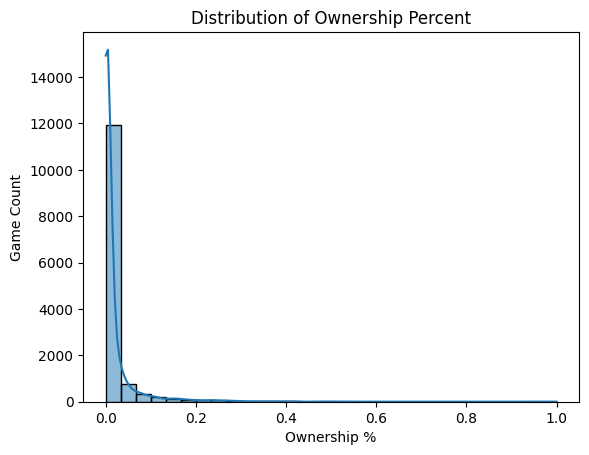

In [193]:
sns.histplot(df2["ownership_percent"], bins=30, kde=True)
plt.title("Distribution of Ownership Percent")
plt.xlabel("Ownership %")
plt.ylabel("Game Count")
plt.show()

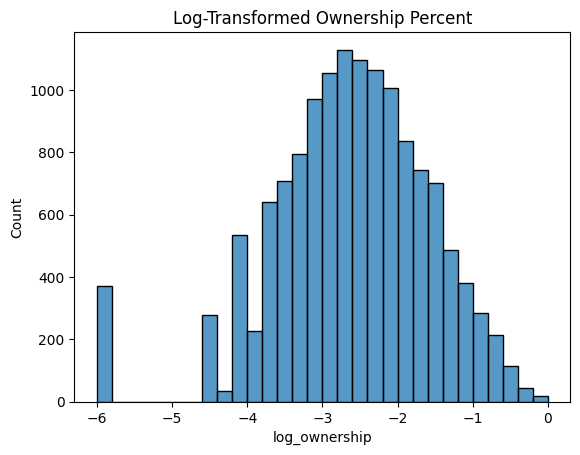

In [194]:
df2["log_ownership"] = np.log10(df2["ownership_percent"] + 1e-6)

# Visualize to choose a threshold (-2.5 ≈ 0.003%)
sns.histplot(df2["log_ownership"], bins=30)
plt.title("Log-Transformed Ownership Percent")
plt.show()

# Create binary popularity class
df2["is_popular"] = df2["log_ownership"] > -3

In [195]:
# Add a column of the availability of games on 3 different platforms
df2["platform_count"] = df2[["ps", "steam", "xbox"]].sum(axis=1)

In [196]:
df2.tail()

,title,achievement_count,price_usd,ownership_percent,years_since_release,num_supported_languages,ps,steam,xbox,is_action,is_adventure,is_rpg,is_shooter,is_sports,is_racing,is_indie,is_open_world,log_ownership,is_popular,platform_count
14814,Speedollama,19,8.99,0.00040,1,0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,-3.396769,False,2.0
14815,Self-Delusion,20,14.99,0.00044,1,0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,-3.355475,False,2.0
14816,Self-Delusion,20,14.99,0.00044,1,0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,-3.355475,False,2.0
14817,Teenage Mutant Ninja Turtles: Mutants Unleashed,27,39.99,0.00132,1,0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,-2.879010,True,3.0
14818,Insectum - Epic Battles of Bugs,13,9.99,0.00044,1,0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,-3.355475,False,2.0


### Correlations

Measures the linear association between one feature and the target `is_popular`.

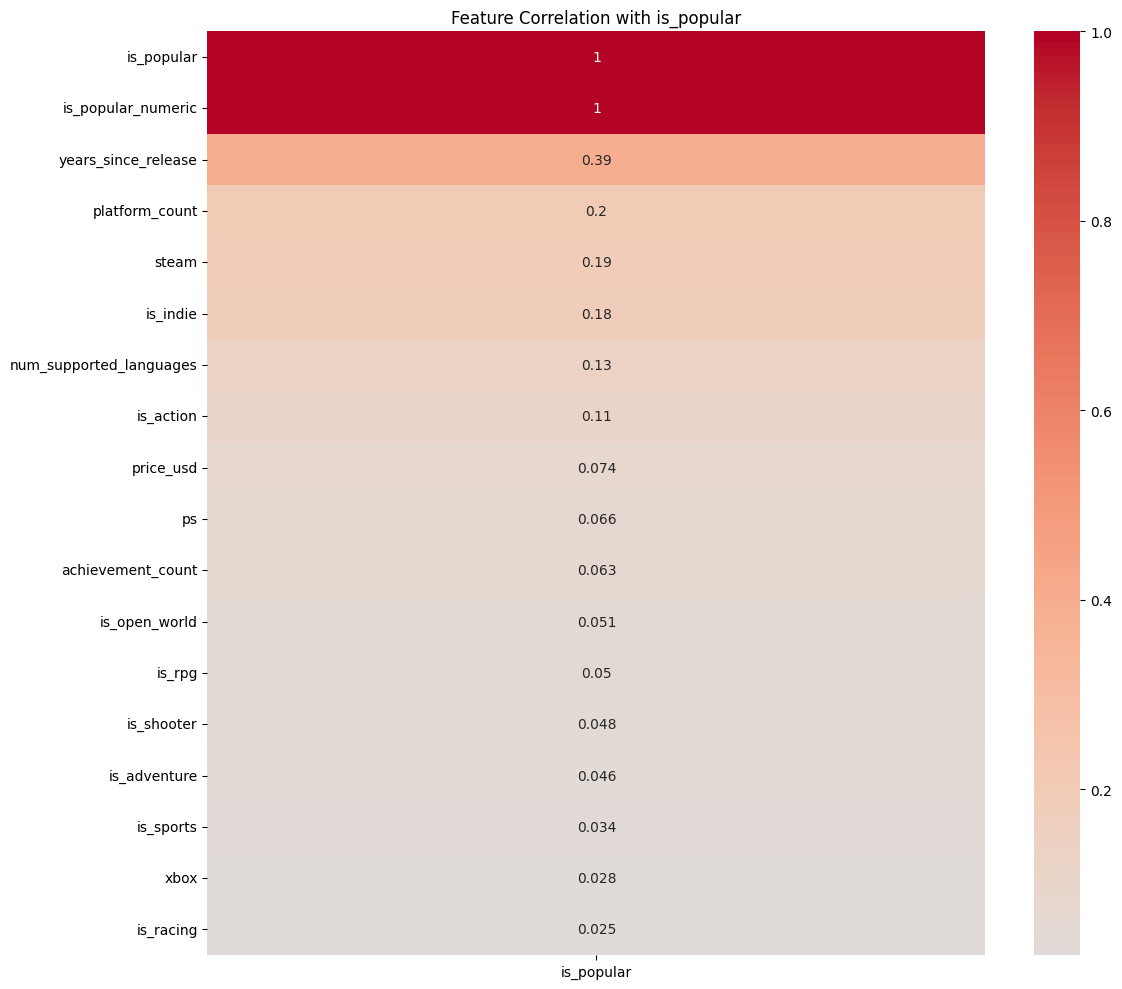

In [197]:
# Heatmap visualizing the correlations between different features and is_popular
df2["is_popular_numeric"] = df2["is_popular"].astype(int)

corr_df = df2.drop(columns=["title", "ownership_percent", "log_ownership", "is_popular"])  # optionally exclude these
corr_df["is_popular"] = df2["is_popular_numeric"]

corr = corr_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr[["is_popular"]].sort_values(by="is_popular", ascending=False), 
            annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation with is_popular")
plt.tight_layout()
plt.show()

In [198]:
feature_cols = df2.drop(columns=["title", "platform_count", "ownership_percent", "log_ownership", "is_popular", "is_popular_numeric"]).columns

X = df2[feature_cols]
y = df2["is_popular"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Random Forest

In [199]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

RF Accuracy: 0.8109978150036417

Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.70      0.71       912
        True       0.85      0.87      0.86      1834

    accuracy                           0.81      2746
   macro avg       0.79      0.78      0.79      2746
weighted avg       0.81      0.81      0.81      2746


Confusion Matrix:
 [[ 637  275]
 [ 244 1590]]


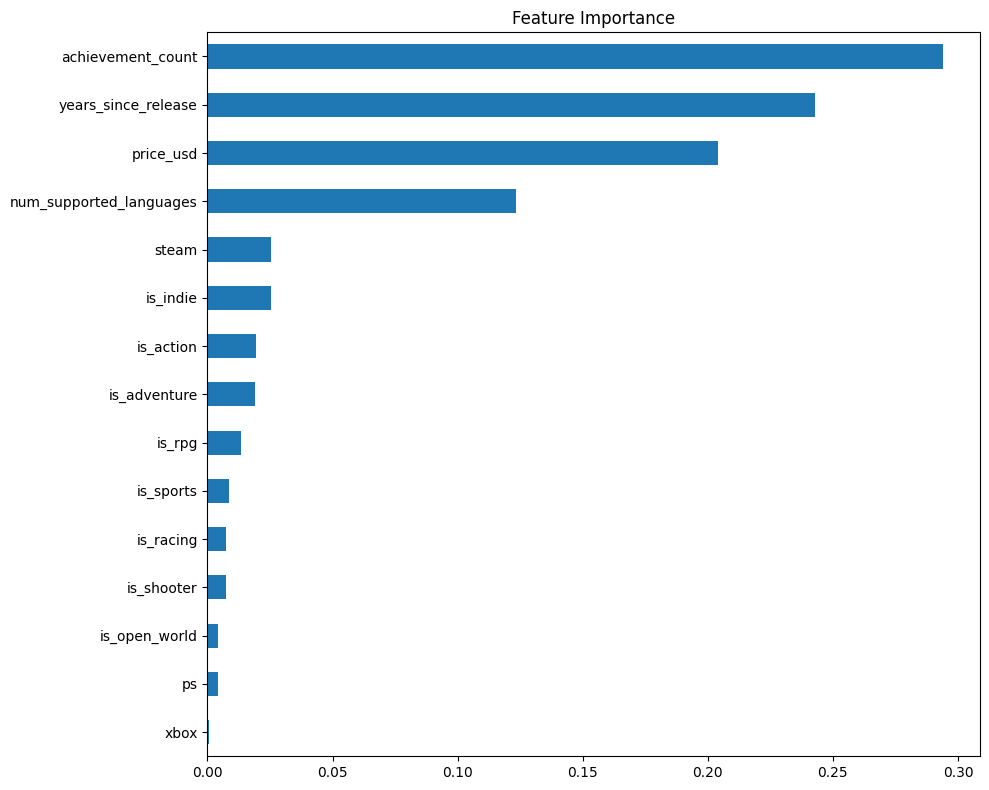

In [200]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values().plot(kind="barh", figsize=(10, 8))
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

### XGBoost

In [201]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

xgb = XGBClassifier(random_state=42, eval_metric="logloss")

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV):", grid_search.best_score_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Score (CV): 0.7982695810564664


In [202]:
best_XGB_model = grid_search.best_estimator_
y_pred_best = best_XGB_model.predict(X_test)

print("XGBoost Accuracy (Tuned):", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

XGBoost Accuracy (Tuned): 0.803714493809177

Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.65      0.69       912
        True       0.84      0.88      0.86      1834

    accuracy                           0.80      2746
   macro avg       0.78      0.77      0.77      2746
weighted avg       0.80      0.80      0.80      2746


Confusion Matrix:
 [[ 594  318]
 [ 221 1613]]


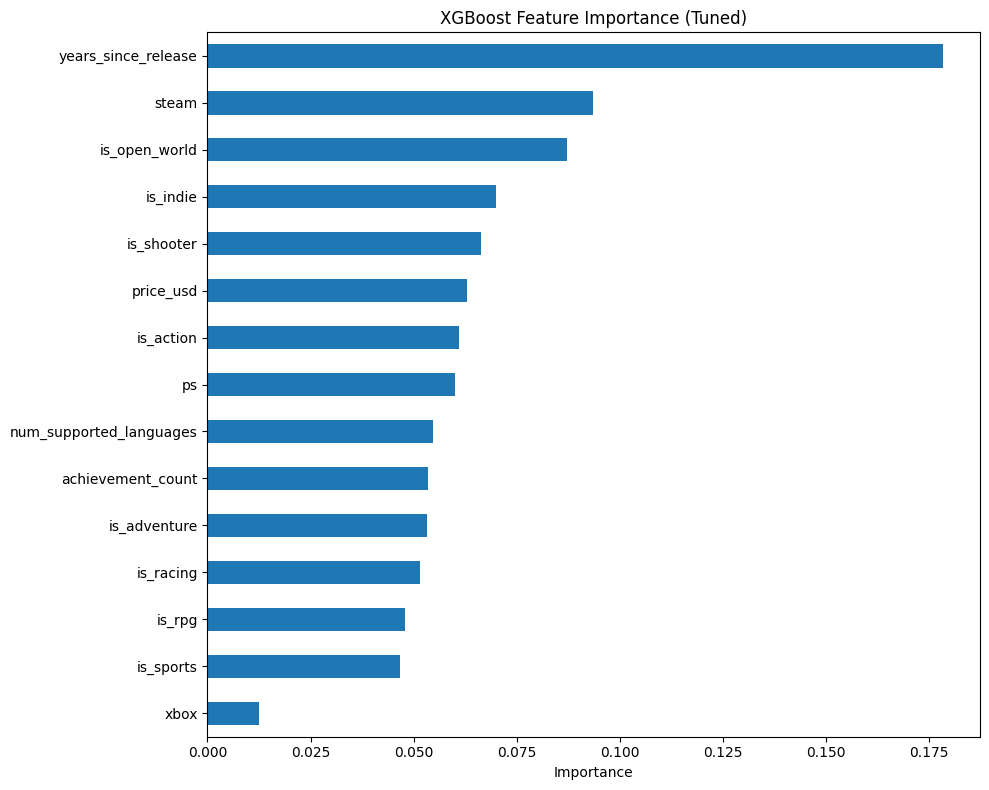

In [203]:
# Feature importance
xgb_importances = pd.Series(best_XGB_model.feature_importances_, index=feature_cols)

# Plot
xgb_importances.sort_values().plot(kind="barh", figsize=(10, 8))
plt.title("XGBoost Feature Importance (Tuned)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Feature Importance 

Interpretation:
- Both models agree that `years_since_release` and `steam` are important, indicating older games and games on Steam tend to be more popular in our datset.
- Random Forest favors numerical intensity (like `achievement_count`, `price_usd`, etc.), which are straightforward to split on.
- XGBoost gives more weight to categorical/binary indicators like genre tags `is_open_world`, `is_indie`, and `is_shooter`, possibly due to its ability to capture subtle interaction effects.
- `achievement_count` is top-ranked in RF but much lower in XGBoost, which shows how models prioritize differently based on how they build and optimize trees.

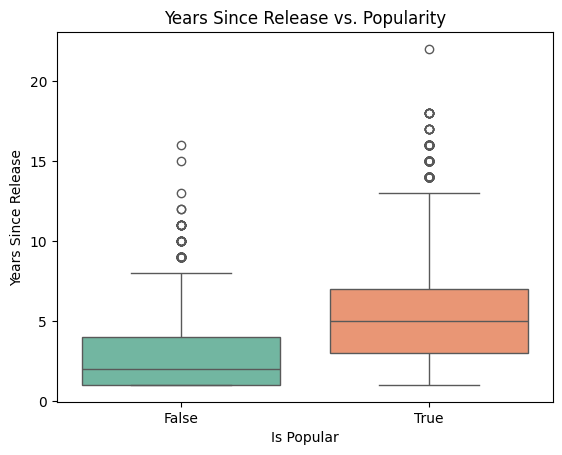

In [206]:
sns.boxplot(x="is_popular", y="years_since_release", data=df2, palette="Set2")
plt.title("Years Since Release vs. Popularity")
plt.xlabel("Is Popular")
plt.ylabel("Years Since Release")
plt.show()

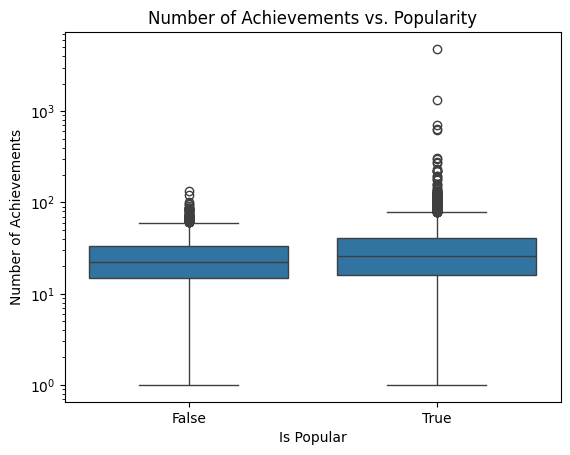

In [208]:
sns.boxplot(x="is_popular", y="achievement_count", data=df2)
plt.title("Number of Achievements vs. Popularity")
plt.xlabel("Is Popular")
plt.ylabel("Number of Achievements")
plt.yscale('log')
plt.show()

#### Correlation V.S. Feature Importance

| Feature                   | Correlation with `is_popular` | Random Forest Rank | XGBoost Rank | Interpretation |
|---------------------------|-------------------------------|--------------------|--------------|----------------|
| `years_since_release`     | 0.39                          | 2nd                | 1st          | Older games tend to be more popular due to accumulated exposure. |
| `achievement_count`       | 0.06                          | 1st                | Mid-low      | Indicates engagement; strong predictor when combined with other features. |
| `platform_count`          | 0.20                          | —                  | —            | More platforms = more reach; however, Steam matters most. |
| `steam`                   | 0.19                          | Mid                | 2nd          | Steam availability strongly aligns with popularity. |
| `price_usd`               | 0.07                          | 3rd                | Mid          | Price alone isn’t decisive, but interacts with other traits. |
| `num_supported_languages` | 0.13                          | 4th                | Lower        | Broader localization supports reach, especially internationally. |
| Genre flags (`is_*`)      | < 0.10                        | Low                | Mid          | Genre alone isn’t predictive, but supports classification when combined with others. |

(Table generated by ChatGPT)

### Interpretation

> Interpret and analyze the classification results, discussing the comparative effectiveness of the classifiers used.

#### Dependent variable/Target of Classification
The raw distribution of ownership percentage is heavily right-skewed, as most games are rarely owned, while a small number dominate. To reduce this distortion and set a meaningful classification threshold, we applied a log transformation. This produced a more Gaussian-like shape, making it easier to work with in modeling. The threshold at log_ownership > -3 gives us a clean split between popular and less popular titles.


#### Classifier Comparison

1. Random Forest
- Accuracy: 81.1%
- Precision/Recall:
  - Popular (True): Precision 0.85, Recall 0.87, F1 0.86
  - Unpopular (False): Precision 0.72, Recall 0.70, F1 0.71

2. XGBoost
- Accuracy: 80.4%
- Precision/Recall:
  - Popular (True): Precision 0.84, Recall 0.88, F1 0.86
  - Unpopular (False): Precision 0.73, Recall 0.65, F1 0.69

In short:
* **Random Forest slightly outperforms XGBoost** in terms of both accuracy and balance across classes.
* XGBoost is more aggressive in classifying popular games, resulting in higher recall for the "popular" class but more false positives.
* Random Forest achieves a **better trade-off between false positives and false negatives**, with a better macro F1-score and slightly more conservative behavior.


#### Feature Importance Analysis: What Drives the Predictions?

**Random Forest Top Features**:
1. Achievement count — strong indicator of player engagement
2. Years since release — recent games aren’t always more popular; some time helps
3. Price — higher price may reflect premium content or perceived value
4. Supported languages — broader localization seems tied to reach

**XGBoost Top Features**:
1. Years since release (again dominant)
2. Genre/type flags like is_open_world, is_shooter, and is_indie
3. Steam availability and price
4. Similar patterns, but with more weight on content and genre structure


#### A Note on Years Since Release
Interestingly, popular games tend to be a bit older — median around 5 years — while less popular games cluster around 2.5 years. This suggests that time plays a role in building reputation and reach, but there’s a limit. Very old games aren’t often in the top either, hinting at a kind of “popularity window” post-launch.


#### Limitations

One important limitation to note is the way popularity was defined. Using a fixed threshold on log-transformed ownership (`log_ownership > -3`) offers a clean binary classification, but it may oversimplify what is actually a continuum of success. Some games just below that threshold may still have meaningful followings or commercial viability, while some above it may only be temporarily inflated.

There’s also an inherent bias in the data itself: games released more recently haven’t had enough time to accumulate long-term ownership, while older games have had years to build an audience. This skews the relationship between `years_since_release` and popularity, and could explain why recency shows up so strongly in both feature importance charts. Similarly, achievements and localization support may correlate with popularity because they’re more common in big-budget games and not because they cause popularity directly.

Both models learn from the data as it is, not as it ought to be. That introduces **algorithmic biases** as well:

- **Random Forest** tends to favor features with **more splits** or **continuous values**, which may explain why `achievement_count`, `price_usd`, and `num_supported_languages` dominate its importance chart. It’s also relatively **conservative** — less likely to make aggressive predictions, which helps avoid over-predicting popularity but may miss emerging hits.

- **XGBoost**, on the other hand, is more **aggressive in boosting weak learners**, which can lead to stronger recall but higher false positives. It may also favor features with strong initial splits, such as `years_since_release`, and place more emphasis on **categorical variables like genre flags** if they create sharp early separations. This makes it more sensitive to noisy or high-cardinality features.

Both models also share a broader **“data completeness” bias** — they perform well when information is rich (many supported languages, clear genres, achievement structures), but likely degrade on sparse, under-documented games.


#### Next Steps
As a next step, we could:
- Reframe the problem as a **regression task** to predict ownership percentage more granularly, rather than just classifying into "popular" vs "not".
- Try a **multi-class popularity tiering** (e.g., low/medium/high) for more nuanced segmentation.
- Incorporate **time-based features** such as months since release or platform-specific release timelines.
- Add **external variables** if available, such as Metacritic scores, publisher information, or visibility on storefronts, to improve model context and performance.
- Apply **cross-model interpretation tools** like SHAP values to better understand not just what features are important, but **how** they influence each prediction. This would also help identify any unintended dependencies the models are leaning on.

Together, we expect these steps would make the analysis more robust, more nuanced, and better suited to handling both high-profile releases and long-tail niche games.


#### Which Model to Choose?

The classification step provided a clearer lens into what drives game popularity, which is something clustering alone couldn’t fully uncover (silhouette score peaked around 0.4). Supervised learning allowed us to move beyond exploratory patterns and directly predict outcomes, with both models reaching over 80% accuracy given the right features.

In terms of model choice, both models are viable, but each serves a different decision-making context. It really comes down to the **goal of the analysis**:

- If the priority is **precision** (for example, allocating a limited marketing budget to only the most likely hits) **Random Forest** is the better fit. It produces more conservative, balanced predictions and is less likely to falsely label a game as popular when it isn’t.

- If the goal is **recall** (such as surfacing more candidates in a recommendation system or identifying early breakout potential) **XGBoost** offers a more aggressive strategy. It’s better at catching popular games, even if it sometimes over-predicts.

In short:  
- Use **Random Forest** when false positives are costly  
- Use **XGBoost** when false negatives are riskier